In [1]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import anderson
from scipy.stats import lognorm
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

In [2]:
def chdir_create_if_not_exists(path):
    """Changes the current working directory to 'path', creating it if necessary."""
    if not os.path.exists(path):
        os.makedirs(path)
    os.chdir(path)

In [3]:
# Plot font format
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

In [4]:
# Specify the subdirectories you want to loop through
ff='Sage2.2.1'
water_model='TIP3P'
replicate_number=3
file_posfix='iso'

for r in range(replicate_number):
    subdirs = [f'{file_posfix}_r1', f'{file_posfix}_r2', f'{file_posfix}_r3']  # List of subdirectories you want to loop through

molecule='CC(C)O'

In [5]:
chdir_create_if_not_exists(f'{ff}/{water_model}')

## EXTRACT DATA

In [6]:
def extract_data(file_name):
    # Specify the subdirectories you want to loop through
    dict_name = {}  # Dictionary to store dict_name

    # Loop through each subdirectory
    for subdir in subdirs:
        length=(len(subdir))
        n_rep=3
        newname=subdir[length-n_rep:]
        # Construct the path to the CSV file (assuming the CSV has the same name as the subdir)
        file_path = os.path.join(os.getcwd(), subdir, f'{file_name}')

        # Read the CSV into a pandas dataframe
        if os.path.exists(file_path):
            if '.csv' in file_name:
                df = pd.read_csv(file_path)
                dict_name[f'df_stats{newname}'] = df
            elif '.json' in file_name:    
                df = pd.read_json(file_path)
            # Store the dataframe with a unique name (using the subdirectory name)
                if 'excess' in file_name:
                    dict_name[f'value{newname}'] = df['.result']['value']['value']
                    dict_name[f'error{newname}'] = df['.result']['value']['error']
                elif 'unpack' in file_name:
                    dict_name[f'molecule_number{newname}'] = df[".total_number_of_molecules"][0]
                    dict_name[f'molefraction_0{newname}'] = df['.substance']['amounts']['CC(C)O{solv}'][0]['value']
                    dict_name[f'molefraction_1{newname}'] = df['.substance']['amounts']['O{solv}'][0]['value']
                elif 'production' in file_name:
                    dict_name[f'production_data{newname}']=df['.observables']['observables']['Enthalpy']['value']['value']['value']
                else:
                    dict_name[f'value{newname}'] = df['.value']['value']['value']
                    dict_name[f'error{newname}'] = df['.value']['value']['error']
                    dict_name[f'n_total_points{newname}'] = df['.time_series_statistics']["n_total_points"]
                    dict_name[f'n_uncorrelated_points{newname}'] = df['.time_series_statistics']["n_uncorrelated_points"]
                    dict_name[f'statistical_inefficiency{newname}'] = df['.time_series_statistics']["statistical_inefficiency"]
                    dict_name[f'equilibration_index{newname}'] = df['.time_series_statistics']["equilibration_index"]

            print(f"Data from {subdir} loaded successfully into dataframe: {subdir}")
        else:
            print(f"Data not found in {subdir}")
    return dict_name

## SYSTEM

In [7]:
def are_values_of_keys_equal(dictionary, keys):
    # Extract the values of the specified keys from the dictionary
    values = [dictionary.get(key) for key in keys]
    
    # Check if all values are the same
    return all(value == values[0] for value in values)

In [8]:
system=extract_data('6439_unpack_data_mixture_output.json')

keys_to_check_molnumber = []
keys_to_check_mf0 = []
keys_to_check_mf1 = []

for key,val in system.items():
    for rep in range(1,(replicate_number+1)):
        if 'molecule_number' in key:
            keys_to_check_molnumber.append(f'{key[:-1]}{rep}')

        if 'molefraction_0' in key:
            # print(f'{key[:-1]}{rep}')
            keys_to_check_mf0.append(f'{key[:-1]}{rep}')

        if 'molefraction_1' in key:
            # print(f'{key[:-1]}{rep}')
            keys_to_check_mf1.append(f'{key[:-1]}{rep}')
            
print(are_values_of_keys_equal(system, keys_to_check_molnumber))
print(are_values_of_keys_equal(system, keys_to_check_mf0))
print(are_values_of_keys_equal(system, keys_to_check_mf1))

Data from iso_r1 loaded successfully into dataframe: iso_r1
Data from iso_r2 loaded successfully into dataframe: iso_r2
Data from iso_r3 loaded successfully into dataframe: iso_r3
True
True
True


In [9]:
print(system['molecule_number_r1'])
print(system['molefraction_0_r1'])
print(system['molefraction_1_r1'])

# thermoml_MF_c1=0.505
# thermoml_MF_c0=0.495
evaluator_MF_c1=system['molefraction_1_r1']
evaluator_MF_c0=system['molefraction_0_r1']

1000
0.505
0.495


In [10]:
molnumb=system['molecule_number_r1']
molnumb_c1=molnumb*evaluator_MF_c1
molnumb_c0=molnumb*evaluator_MF_c0

## FUNCTIONS

In [11]:
def ts_energy(data_dict, energy, typesim):
    colors = ['red', 'orange', 'gold', 'green', 'blue', 'darkviolet']
    labels = [f'rep {i+1}' for i in range(len(data_dict))]

    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(9, 5))

    for i in range(len(data_dict)):
        plt.plot(range(len(data_dict[i])), data_dict[i], linestyle='-', color=colors[i], alpha=0.5, label=labels[i], lw=2)

    plt.xlabel("Trajectory step", fontsize=MEDIUM_SIZE)
    plt.ylabel(f"{energy}", fontsize=MEDIUM_SIZE)
    plt.title(f'{typesim} {energy} vs Trajectory {file_posfix}', fontsize=BIGGER_SIZE)
    plt.legend(prop={'size': 8}, loc='lower left')
    # plt.savefig(f'mixture_enthalpy_plt_{file_posfix}.png')
    plt.show()


In [12]:
def timeseries_overlap(data_dict, typesim):
    colors = ['red', 'orange', 'gold', 'green', 'blue', 'darkviolet']
    labels = [f'rep {i+1}' for i in range(len(data_dict))]

    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(12.0, 7.0))

    for i in range(len(data_dict)):
        plt.plot(range(len(data_dict[i])), [y / molnumb for y in data_dict[i]], linestyle='-', color=colors[i], label=labels[i], lw=2)

    plt.xlabel("Trajectory step", fontsize=MEDIUM_SIZE)
    plt.ylabel("Enthalpy (kJ/mol)", fontsize=MEDIUM_SIZE)
    plt.title(f'{typesim} Enthalpy vs Trajectory {molecule} {file_posfix}', fontsize=BIGGER_SIZE)
    plt.legend(loc='lower left', prop={'size': 8})  # Legend positioned at bottom left
    # plt.savefig(f'mixture_enthalpy_plt_{file_posfix}.png')
    plt.show()

In [13]:
def timeseriesplot(data_dict):
    
    plt.rcParams.update({'font.size': 16})

    # Create individual plots for each replicate
    colors = ['red', 'orange', 'gold', 'green', 'blue', 'darkviolet']
    labels = ['rep 1', 'rep 2', 'rep 3', 'rep 4', 'rep 5', 'rep 6']

    for i in range(replicate_number):
        x=range(len(data_dict[i]))
        plt.figure(figsize=(7, 4))
        
        # Plot histogram for each replicate
        plt.plot(x, [y/molnumb for y in data_dict[i]], linestyle='-', color=colors[i], lw=2, label=labels[i])
        
        # Labels and title
        plt.xlabel("Trajectory step", fontsize=SMALL_SIZE)
        plt.ylabel("Enthalpy (kJ/mol)", fontsize=SMALL_SIZE)
        plt.title(f'{labels[i]} Enthalpy time series {molecule} {file_posfix}', fontsize=SMALL_SIZE)
        
        # Add legend
        plt.legend(prop={'size': 10})
        
        # Save and show the plot
        # plt.savefig(f'mixture_enthalpy_hist_gaussian_{labels[i]}_{file_posfix}.png')
        plt.show()

In [14]:
def dists_allinone(data_dict):
    import scipy.stats as stats

    # Set up font size
    plt.rcParams.update({'font.size': 12})

    # Create the figure
    plt.figure(figsize=(7.0, 3.0))

    # Define a function to plot the Gaussian for comparison
    def plot_gaussian(data, color, label):
        mean = np.mean(data)
        std = np.std(data)
        xmin, xmax = plt.xlim()  # Get current x limits from the histogram
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mean, std)
        plt.plot(x, p, color=color, linestyle='--', lw=2, label=f'{label} Gaussian')

    # Plot histograms and Gaussian curves for each repetition
    for i, color, label in zip(range(replicate_number), ['red', 'orange', 'gold', 'green', 'blue', 'darkviolet'], 
                            ['rep 1', 'rep 2', 'rep 3', 'rep 4', 'rep 5', 'rep 6']):
        plt.hist([y/molnumb for y in data_dict[i]], bins=30, color=color, alpha=0.5, density=True, label=label)
        plot_gaussian([y/molnumb for y in data_dict[i]], color, label)

    # Labels and title
    plt.xlabel("Enthalpy (kJ/mol)", fontsize=SMALL_SIZE)
    plt.ylabel("Density", fontsize=SMALL_SIZE)
    plt.title(f'Mixture Enthalpy Distribution {molecule} {file_posfix}', fontsize=SMALL_SIZE)

    # Add legend
    plt.legend(prop={'size': 8})

    # Save and show the plot
    # plt.savefig(f'mixture_enthalpy_hist_gaussian_{file_posfix}.png')
    plt.show()


In [77]:
def dists_indiv(data_dict,component):
    import scipy.stats as stats

    # Set up font size
    plt.rcParams.update({'font.size': 12})

    def plot_gaussian(data, color, label):
        # Convert data to a NumPy array if it's a list
        data = np.array(data)

        # Calculate mean and standard deviation
        mean = np.mean(data)
        std = np.std(data)

        print(f'mean: {mean}')
        print(f'stdv: {std}')

        # Get current x limits from the histogram
        xmin, xmax = plt.xlim()  
        x = np.linspace(xmin, xmax, 100)
        
        # Calculate Gaussian probability density function
        p = stats.norm.pdf(x, mean, std)
        
        # Plot Gaussian curve
        plt.plot(x, p, color=color, linestyle='--', lw=2, label=f'Gaussian - stdv={std:.3f}')
        plt.legend()

        # Shapiro-Wilk normality test
        stat, pval = shapiro(data)
        alpha_val = 0.05
        print('Shapiro Statistics=%.3f, p=%.3f' % (stat, pval))
        if pval > alpha_val:
            print('Shapiro: Sample looks Gaussian (fail to reject H0)')
        else:
            print('Shapiro: Sample does not look Gaussian (reject H0)')

        # Anderson-Darling normality test
        ad_result = anderson(data)
        print('Anderson-Darling Statistic: %.3f' % ad_result.statistic)
        for i in range(len(ad_result.critical_values)):
            sl, cv = ad_result.significance_level[i], ad_result.critical_values[i]
            if ad_result.statistic < ad_result.critical_values[i]:
                print('Anderson-Darling: %.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
            else:
                print('Anderson-Darling: %.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

        # Kolmogorov-Smirnov normality test
        ks_stat, ks_p = kstest(data, 'norm', args=(mean, std))
        print('Kolmogorov-Smirnov Statistics=%.3f, p=%.3f' % (ks_stat, ks_p))
        if ks_p > alpha_val:
            print('Kolmogorov-Smirnov: Sample looks Gaussian (fail to reject H0)')
        else:
            print('Kolmogorov-Smirnov: Sample does not look Gaussian (reject H0)')

        # Q-Q plot
        sm.qqplot(data, line='s')
        plt.title(f'Q-Q Plot for {label} - {molecule}{file_posfix}')
        plt.show()

    # Create individual plots for each replicate
    colors = ['red', 'orange', 'gold', 'green', 'blue', 'darkviolet']
    labels = ['rep 1', 'rep 2', 'rep 3', 'rep 4', 'rep 5', 'rep 6']

    for i in range(replicate_number):
        plt.figure(figsize=(7, 4))
        # Plot Gaussian curve for each replicate
        # plotg=plot_gaussian([y/molnumb for y in data_dict[i]], colors[i], label=labels[i])
        # plot_gaussian([y/molnumb for y in data_dict[i]], colors[i], label=labels[i])
        # Plot histogram for each replicate
        plt.hist([y/molnumb for y in data_dict[i]], bins=30, color=colors[i], alpha=0.5, density=True, label=f'{labels[i]}')
        # Labels and title
        plt.xlabel("Enthalpy (kJ/mol)", fontsize=SMALL_SIZE)
        plt.ylabel("Density", fontsize=SMALL_SIZE)
        plt.title(f'{labels[i]} {component} Enthalpy Distribution with Gaussian Fit {molecule}{file_posfix}', fontsize=SMALL_SIZE)
        # Add legend
        plt.legend(prop={'size': 10})

        # Plot Gaussian curve for each replicate
        plot_gaussian([y/molnumb for y in data_dict[i]], colors[i], labels[i])

        # Save and show the plot
        # plt.savefig(f'mixture_enthalpy_hist_gaussian_{labels[i]}_{file_posfix}.png')
        plt.show()


In [16]:
def sigma_counts(data_dict):
    # Function to calculate the counts within an exact standard deviation range
    def count_within_exact_std(data, lower_n_std, upper_n_std):
        mean = np.mean(data)
        std = np.std(data)
        within_range = ((data >= mean - upper_n_std * std) & (data <= mean + upper_n_std * std)) & \
                    ~((data >= mean - lower_n_std * std) & (data <= mean + lower_n_std * std))
        return within_range.sum()

    # Prepare the standard deviation ranges and labels
    std_ranges = [1, 2, 3, 4, '5+']
    colors = ['red', 'orange', 'gold', 'green', 'blue', 'darkviolet']
    labels = ['rep 1', 'rep 2', 'rep 3', 'rep 4', 'rep 5', 'rep 6']

    # Create a bar chart for each replicate
    for i in range(replicate_number):
        counts = []
        # Calculate counts for each standard deviation range (e.g., between 1 and 2 stds)
        counts.append(count_within_exact_std(data_dict[i], 0, 1))  # 0-1 sigma
        counts.append(count_within_exact_std(data_dict[i], 1, 2))  # 1-2 sigma
        counts.append(count_within_exact_std(data_dict[i], 2, 3))  # 2-3 sigma
        counts.append(count_within_exact_std(data_dict[i], 3, 4))  # 3-4 sigma
        counts.append(count_within_exact_std(data_dict[i], 4, 50))  # 3-4 sigma

        # Create a figure for each replicate
        plt.figure(figsize=(8, 5))

        # Plot the bar chart
        bars = plt.bar([f'{n} sigma' for n in std_ranges], counts, color=colors[i], alpha=0.7)

        # Add labels (count values) on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}', 
                    ha='center', va='bottom', fontsize=MEDIUM_SIZE, color='black')
        # plt.ylim(0,650)
        # Labels and title
        plt.xlabel('Standard Deviation Range', fontsize=MEDIUM_SIZE)
        plt.ylabel('Count', fontsize=MEDIUM_SIZE)
        plt.title(f'{labels[i]}: Count within Standard Deviations {molecule}{file_posfix}', fontsize=BIGGER_SIZE)

        # Save and show the plot
        # plt.savefig(f'std_count_bar_exact_{labels[i]}_{file_posfix}.png')
        plt.show()


In [17]:
# Function to remove data points beyond 3 standard deviations
def remove_outliers(data, n_std=3):
    # Ensure the data is a NumPy array
    data = np.array(data)
    
    mean = np.mean(data)
    std = np.std(data)
    
    # Keep only data points that are within +/- 3 standard deviations
    within_range = (data >= mean - n_std * std) & (data <= mean + n_std * std)
    
    print(f"Number of data points removed: {(~within_range).sum()}")
    
    # Return the filtered data
    return data[within_range]

In [18]:
def filtered_results(data_dict):
    # List to store the means of filtered data for each replicate
    filtered_means = []

    # Loop over each replicate in mix_prod_enthalpy
    for i in range(replicate_number):
        # Calculate the mean of the filtered data
        mean_filtered_data = np.mean([y/molnumb for y in data_dict[i]])
        
        # Store the mean in the list
        filtered_means.append(mean_filtered_data)

    # Convert the list of means to a NumPy array
    filtered_means = np.array(filtered_means)

    # Calculate the standard deviation of the means
    std_of_means = np.std(filtered_means)

    # Print the results
    print(f"Means of filtered data for each replicate: {filtered_means}")
    print(f"Standard deviation of the means: {std_of_means}")


In [73]:
def dists_indiv_energy(data_dict, energy):
    import scipy.stats as stats

    # Set up font size
    plt.rcParams.update({'font.size': 12})

    def plot_gaussian(data, color, label):
        # Convert data to a NumPy array if it's a list
        data = np.array(data)

        # Calculate mean and standard deviation
        mean = np.mean(data)
        std = np.std(data)

        print(f'mean: {mean}')
        print(f'stdv: {std}')

        # Get current x limits from the histogram
        xmin, xmax = plt.xlim()  
        x = np.linspace(xmin, xmax, 100)
        
        # Calculate Gaussian probability density function
        p = stats.norm.pdf(x, mean, std)
        
        # Plot Gaussian curve
        plt.plot(x, p, color=color, linestyle='--', lw=2, label=f'Gaussian; stdev={std:.3f}')
        plt.legend()

        # Shapiro-Wilk normality test
        stat, pval = shapiro(data)
        alpha_val = 0.05
        print('Shapiro Statistics=%.3f, p=%.3e' % (stat, pval))
        if pval > alpha_val:
            print('Shapiro: Sample looks Gaussian (fail to reject H0)')
        else:
            print('Shapiro: Sample does not look Gaussian (reject H0)')

        # Anderson-Darling normality test
        ad_result = anderson(data)
        print('Anderson-Darling Statistic: %.3f' % ad_result.statistic)
        for i in range(len(ad_result.critical_values)):
            sl, cv = ad_result.significance_level[i], ad_result.critical_values[i]
            if ad_result.statistic < ad_result.critical_values[i]:
                print('Anderson-Darling: %.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
            else:
                print('Anderson-Darling: %.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

        # Kolmogorov-Smirnov normality test
        ks_stat, ks_p = kstest(data, 'norm', args=(mean, std))
        print('Kolmogorov-Smirnov Statistics=%.3f, p=%.3e' % (ks_stat, ks_p))
        if ks_p > alpha_val:
            print('Kolmogorov-Smirnov: Sample looks Gaussian (fail to reject H0)')
        else:
            print('Kolmogorov-Smirnov: Sample does not look Gaussian (reject H0)')

        # Q-Q plot
        sm.qqplot(data, line='s')
        plt.title(f'Q-Q Plot for {label}')
        plt.show()
        # return std

    # Create individual plots for each replicate
    colors = ['red', 'orange', 'gold', 'green', 'blue', 'darkviolet']
    labels = ['rep 1', 'rep 2', 'rep 3', 'rep 4', 'rep 5', 'rep 6']

    for i in range(replicate_number):
        plt.figure(figsize=(7, 4))
        # Plot Gaussian curve for each replicate
        # plotg=plot_gaussian([y/molnumb for y in data_dict[i]], colors[i], label=labels[i])
        # plot_gaussian([y/molnumb for y in data_dict[i]], colors[i], label=labels[i])
        # Plot histogram for each replicate
        plt.hist([y/molnumb for y in data_dict[i]], bins=30, color=colors[i], alpha=0.5, density=True, label=f'{labels[i]}')
        # Labels and title
        plt.xlabel(f"{energy}", fontsize=SMALL_SIZE)
        plt.ylabel("Density", fontsize=SMALL_SIZE)
        plt.title(f'{labels[i]} {energy} Distribution with Gaussian Fit {file_posfix}', fontsize=SMALL_SIZE)
        # Add legend
        plt.legend(prop={'size': 10})

        # Plot Gaussian curve for each replicate
        plot_gaussian([y/molnumb for y in data_dict[i]], colors[i], label=labels[i])

        # Save and show the plot
        # plt.savefig(f'mixture_enthalpy_hist_gaussian_{labels[i]}_{file_posfix}.png')
        plt.show()


## FINAL RESULTS

In [20]:
os.getcwd()

'/media/bamo6610/DATA/evaluator-blanca/watermix_analysis_reps/Sage2.2.1/TIP3P'

In [21]:
final_results=extract_data('6439_calculate_excess_observable_output.json')

obs_values=[]
obs_errors=[]
for key, mr in final_results.items():
    if 'value' in key:
        print(f"{key}:{mr['value']}")
        obs_values.append(mr['value'])
    elif 'error' in key:
        print(f"{key}:{mr['value']}")
        obs_errors.append(mr['value'])

with open(f'output_observables_{file_posfix}.txt', 'w') as file:
    file.write(f'Values list: {obs_values} \n')
    file.write(f'Errors list: {obs_errors} \n')

Data from iso_r1 loaded successfully into dataframe: iso_r1
Data from iso_r2 loaded successfully into dataframe: iso_r2
Data from iso_r3 loaded successfully into dataframe: iso_r3
value_r1:1.170665932726571
error_r1:0.025482076723930002
value_r2:1.249287277177696
error_r2:0.032817181153058005
value_r3:1.201956235921969
error_r3:0.025416797311281002


## MIXTURE

### ENERGY STATS - MIXTURE

In [22]:
# eq_stats=extract_data('openmm_statistics_eqmix.csv')

# eqmix_stats={}
# for i in range(len(subdirs)):
#     eqmix_stats[i] = eq_stats[f'df_stats_r{i+1}']

# eqmix_boxvol=[]
# eqmix_dens=[]

# for key, value_list in eqmix_stats.items():
#     eqmix_boxvol.append(value_list['Box Volume (nm^3)'])
#     eqmix_dens.append(value_list['Density (g/mL)'])


# eqmix_boxvol=np.array(eqmix_boxvol)
# eqmix_dens=np.array(eqmix_dens)

# starteq_ps100_vol=[]
# for i in range(len(eqmix_boxvol)):
#     first10=eqmix_boxvol[i][:10]
#     starteq_ps100_vol.append(first10.mean())
# print('Start of equilibration mix VOLUME 100 ps average',starteq_ps100_vol)

# starteq_ps100_dens=[]
# for i in range(len(eqmix_dens)):
#     first10=eqmix_dens[i][:10]
#     starteq_ps100_dens.append(first10.mean())
# print('Start of equilibration mix DENS 100 ps average',starteq_ps100_dens)
# print('Mean: ', np.mean(starteq_ps100_dens))


# endeq_ps100_vol=[]
# for i in range(len(eqmix_boxvol)):
#     last10=eqmix_boxvol[i][-10:]
#     endeq_ps100_vol.append(last10.mean())
# print('End of equilibration mix VOLUME 100 ps average',endeq_ps100_vol)

# endeq_ps100_dens=[]
# for i in range(len(eqmix_dens)):
#     last10=eqmix_dens[i][-10:]
#     endeq_ps100_dens.append(last10.mean())
# print('End of equilibration mix DENS 100 ps average',endeq_ps100_dens)
# print('Mean: ', np.mean(endeq_ps100_dens))

In [23]:
prod_stats=extract_data('openmm_statistics_mix.csv')

prodmix_stats={}
for i in range(len(subdirs)):
    prodmix_stats[i] = prod_stats[f'df_stats_r{i+1}']

prodmix_boxvol=[]
prodmix_dens=[]

for key, value_list in prodmix_stats.items():
    prodmix_boxvol.append(value_list['Box Volume (nm^3)'])
    prodmix_dens.append(value_list['Density (g/mL)'])


prodmix_boxvol=np.array(prodmix_boxvol)
prodmix_dens=np.array(prodmix_dens)

startprod_ps100_vol=[]
for i in range(len(prodmix_boxvol)):
    first25=prodmix_boxvol[i][:25]
    startprod_ps100_vol.append(first25.mean())
print('Start of production mix VOLUME 100 ps average',startprod_ps100_vol)

startprod_ps100_dens=[]
for i in range(len(prodmix_dens)):
    first25=prodmix_dens[i][:25]
    startprod_ps100_dens.append(first25.mean())
print('Start of production mix DENS 100 ps average',startprod_ps100_dens)



endprod_ps100_vol=[]
for i in range(len(prodmix_boxvol)):
    last25=prodmix_boxvol[i][-25:]
    endprod_ps100_vol.append(last25.mean())
print('End of production mix VOLUME 100 ps average',endprod_ps100_vol)

endprod_ps100_dens=[]
for i in range(len(prodmix_dens)):
    last25=prodmix_dens[i][-25:]
    endprod_ps100_dens.append(last25.mean())
print('End of production mix DENS 100 ps average',endprod_ps100_dens)

Data from iso_r1 loaded successfully into dataframe: iso_r1
Data from iso_r2 loaded successfully into dataframe: iso_r2
Data from iso_r3 loaded successfully into dataframe: iso_r3
Start of production mix VOLUME 100 ps average [80.40212933835458, 79.98333584576805, 80.5269742263655]
Start of production mix DENS 100 ps average [0.8110011525188676, 0.8152323495248252, 0.809748214963141]
End of production mix VOLUME 100 ps average [80.21691329707188, 79.82281958326209, 80.06524763535091]
End of production mix DENS 100 ps average [0.8128776556406682, 0.8168805921737234, 0.814397690211366]


In [24]:
stats=extract_data('openmm_statistics_mix.csv')

means_stats={}
for i in range(len(subdirs)):
    means_stats[i] = stats[f'df_stats_r{i+1}'].mean()

PE=[]
KE=[]
TE=[]
temp=[]
bVol=[]
dens=[]

for key, value_list in means_stats.items():
    # print(f'Key: {key}')
    # print(f'Values: {value_list}')
    PE.append(value_list.iloc[1])
    KE.append(value_list.iloc[2])
    TE.append(value_list.iloc[3])
    temp.append(value_list.iloc[4])
    bVol.append(value_list.iloc[5])
    dens.append(value_list.iloc[6])

## Calculate means and MSE
PE_mean=np.array(PE).mean()
PE_std=np.array(PE).std(ddof=1)
PE_err=PE_std/np.sqrt(len(PE))
print(f'Hmix replicates, Potential Energy (kJ/mol): {PE_mean:.3f} +/- {PE_err:.3f}')

KE_mean=np.array(KE).mean()
KE_std=np.array(KE).std(ddof=1)
KE_err=KE_std/np.sqrt(len(KE))
print(f'Hmix replicates, Kinetic Energy (kJ/mol): {KE_mean:.3f} +/- {KE_err:.3f}')

TE_mean=np.array(TE).mean()
TE_std=np.array(TE).std(ddof=1)
TE_err=TE_std/np.sqrt(len(TE))
print(f'Hmix replicates, Total Energy (kJ/mol): {TE_mean:.3f} +/- {TE_err:.3f}')

Temp_mean=np.array(temp).mean()
Temp_std=np.array(temp).std(ddof=1)
Temp_err=Temp_std/np.sqrt(len(temp))
print(f'Hmix replicates, Temperature (K): {Temp_mean:.3f} +/- {Temp_err:.3f}')

bVol_mean=np.array(bVol).mean()
bVol_std=np.array(bVol).std(ddof=1)
bVol_err=bVol_std/np.sqrt(len(bVol))
print(f'Hmix replicates, Box Volume (nm^3): {bVol_mean:.3f} +/- {bVol_err:.3f}')

dens_mean=np.array(dens).mean()
dens_std=np.array(dens).std(ddof=1)
dens_err=dens_std/np.sqrt(len(dens))
print(f'Hmix replicates, Density (g/mL): {dens_mean:.3f} +/- {dens_err:.3f}')

with open(f'mix_stats_{file_posfix}.txt', 'w') as file:
    # file.write(f'Molecule number: {molnumb} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Potential Energy (kJ/mol): {PE_mean:.3f} +/- {PE_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Kinetic Energy (kJ/mol): {KE_mean:.3f} +/- {KE_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Total Energy (kJ/mol): {TE_mean:.3f} +/- {TE_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Temperature (K): {Temp_mean:.3f} +/- {Temp_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Box Volume (nm^3): {bVol_mean:.3f} +/- {bVol_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Density (g/mL): {dens_mean:.3f} +/- {dens_err:.3f} \n')

Data from iso_r1 loaded successfully into dataframe: iso_r1
Data from iso_r2 loaded successfully into dataframe: iso_r2
Data from iso_r3 loaded successfully into dataframe: iso_r3
Hmix replicates, Potential Energy (kJ/mol): -43111.865 +/- 24.049
Hmix replicates, Kinetic Energy (kJ/mol): 22299.418 +/- 5.375
Hmix replicates, Total Energy (kJ/mol): -20812.447 +/- 29.401
Hmix replicates, Temperature (K): 313.501 +/- 0.076
Hmix replicates, Box Volume (nm^3): 80.098 +/- 0.040
Hmix replicates, Density (g/mL): 0.814 +/- 0.000


In [25]:
PE_ts_mix={}
KE_ts_mix={}
TE_ts_mix={}
temp_ts_mix={}
bvol_ts_mix={}
dens_ts_mix={}
for i in range(3):
    PE_ts_mix[i]=stats[f'df_stats_r{i+1}']['Potential Energy (kJ/mole)']
    KE_ts_mix[i]=stats[f'df_stats_r{i+1}']['Kinetic Energy (kJ/mole)']
    TE_ts_mix[i]=stats[f'df_stats_r{i+1}']['Total Energy (kJ/mole)']
    temp_ts_mix[i]=stats[f'df_stats_r{i+1}']['Temperature (K)']
    bvol_ts_mix[i]=stats[f'df_stats_r{i+1}']['Box Volume (nm^3)']
    dens_ts_mix[i]=stats[f'df_stats_r{i+1}']['Density (g/mL)']

In [26]:
type(PE_ts_mix)

dict

In [27]:
list(PE_ts_mix.keys())

[0, 1, 2]

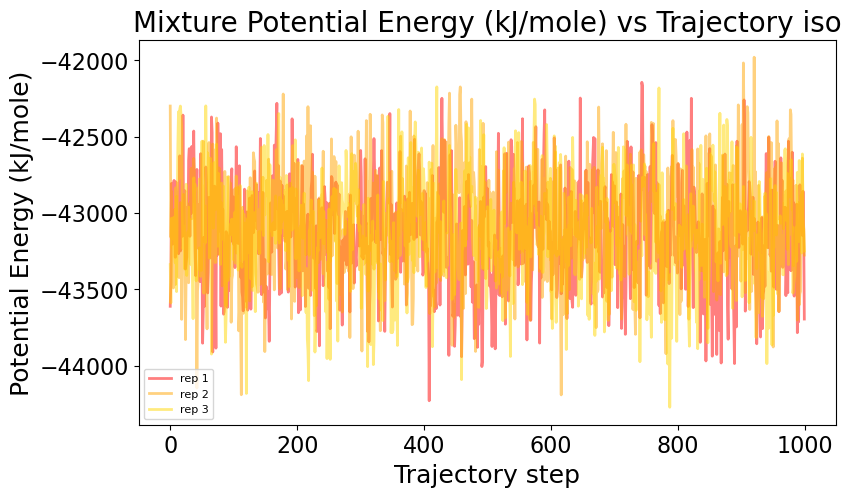

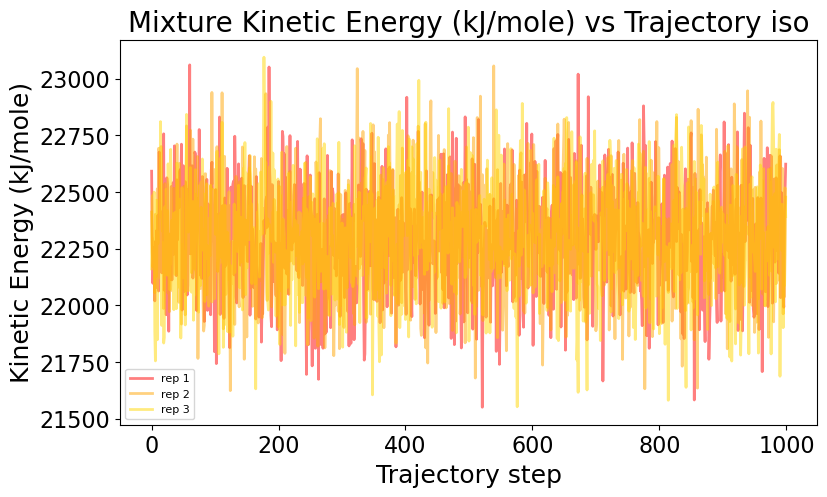

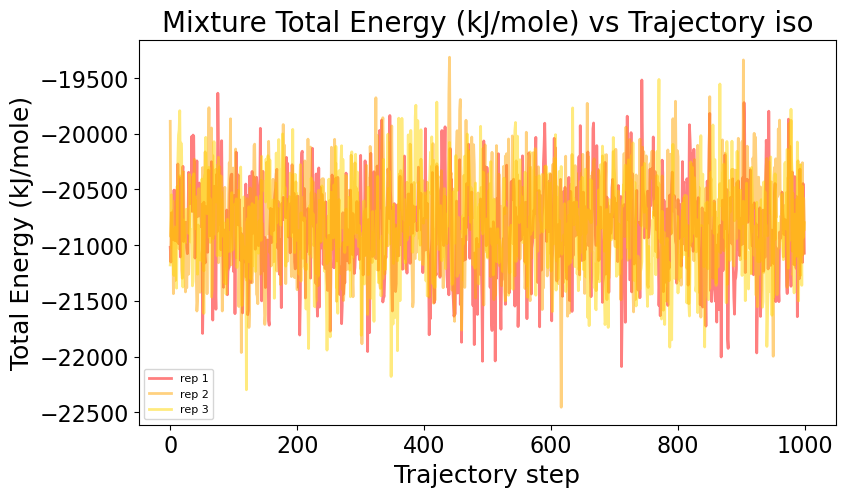

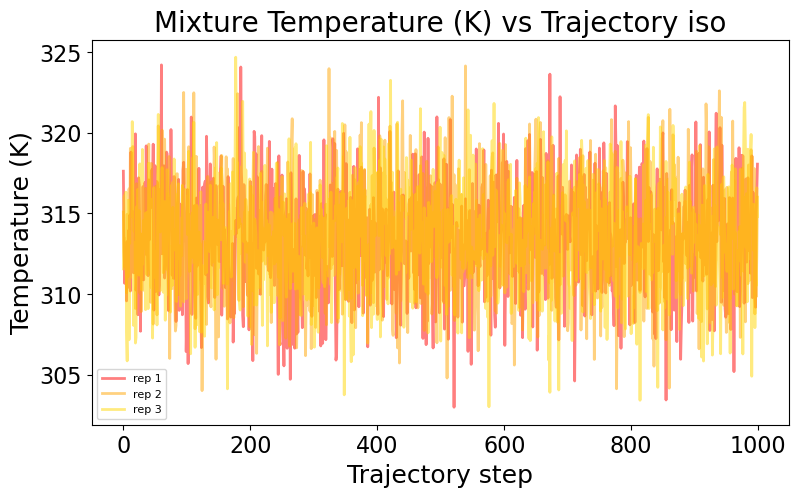

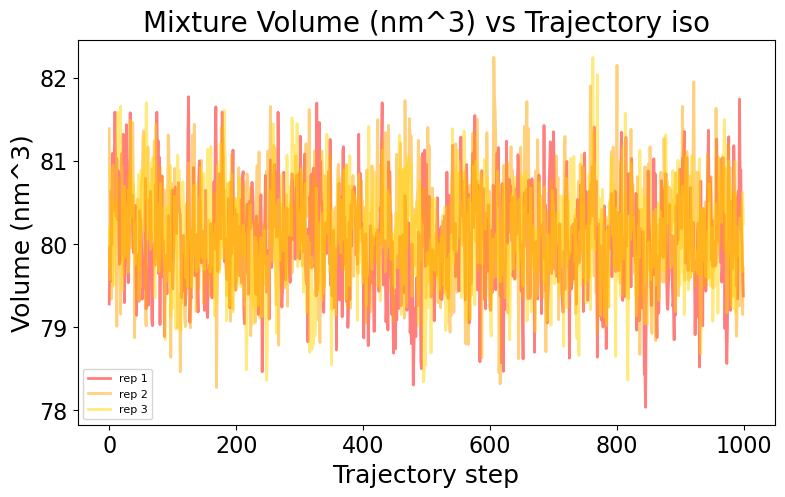

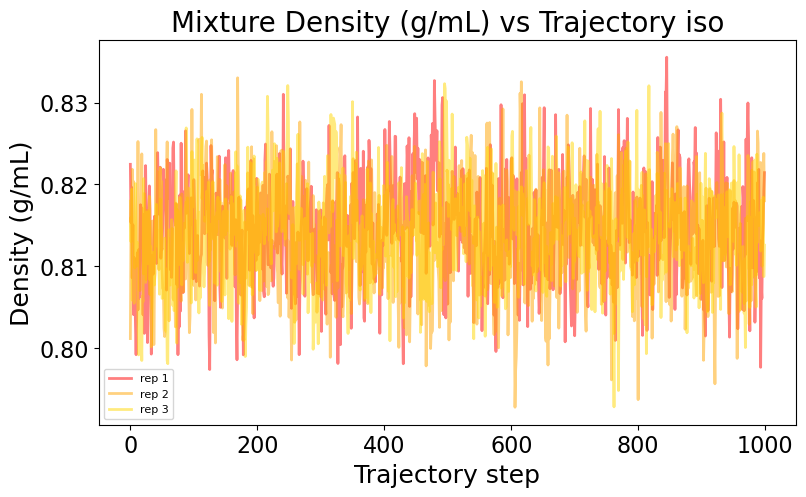

In [28]:
pe_mix_fig=ts_energy(PE_ts_mix,'Potential Energy (kJ/mole)','Mixture')
ke_mix_fig=ts_energy(KE_ts_mix,'Kinetic Energy (kJ/mole)','Mixture')
te_mix_fig=ts_energy(TE_ts_mix,'Total Energy (kJ/mole)','Mixture')
temp_mix_fig=ts_energy(temp_ts_mix,'Temperature (K)','Mixture')
bvol_mix_fig=ts_energy(bvol_ts_mix,'Volume (nm^3)', 'Mixture')
dens_mix_fig=ts_energy(dens_ts_mix,'Density (g/mL)', 'Mixture')

mean: 22.293198170189044
stdv: 0.23980503875885276
Shapiro Statistics=0.999, p=6.125e-01
Shapiro: Sample looks Gaussian (fail to reject H0)
Anderson-Darling Statistic: 0.302
Anderson-Darling: 15.000: 0.574, data looks normal (fail to reject H0)
Anderson-Darling: 10.000: 0.653, data looks normal (fail to reject H0)
Anderson-Darling: 5.000: 0.784, data looks normal (fail to reject H0)
Anderson-Darling: 2.500: 0.914, data looks normal (fail to reject H0)
Anderson-Darling: 1.000: 1.088, data looks normal (fail to reject H0)
Kolmogorov-Smirnov Statistics=0.017, p=9.369e-01
Kolmogorov-Smirnov: Sample looks Gaussian (fail to reject H0)


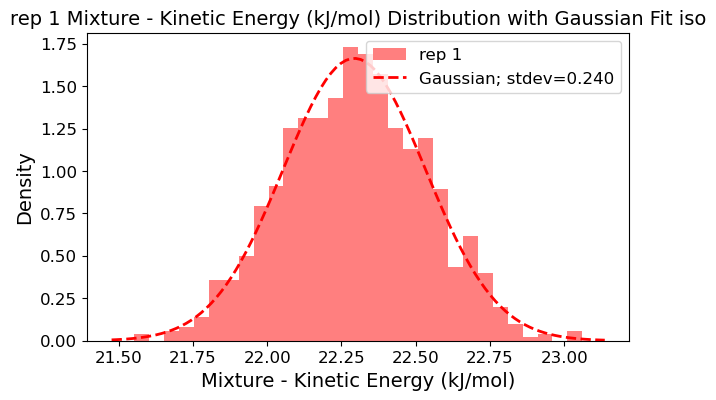

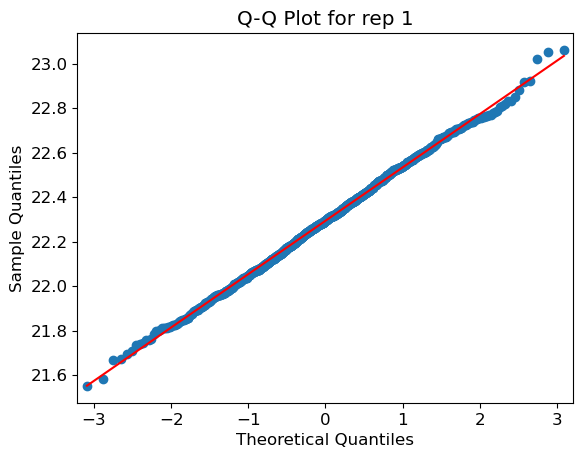

mean: 22.31012046675111
stdv: 0.23673070163464363
Shapiro Statistics=0.999, p=8.363e-01
Shapiro: Sample looks Gaussian (fail to reject H0)
Anderson-Darling Statistic: 0.212
Anderson-Darling: 15.000: 0.574, data looks normal (fail to reject H0)
Anderson-Darling: 10.000: 0.653, data looks normal (fail to reject H0)
Anderson-Darling: 5.000: 0.784, data looks normal (fail to reject H0)
Anderson-Darling: 2.500: 0.914, data looks normal (fail to reject H0)
Anderson-Darling: 1.000: 1.088, data looks normal (fail to reject H0)
Kolmogorov-Smirnov Statistics=0.024, p=5.844e-01
Kolmogorov-Smirnov: Sample looks Gaussian (fail to reject H0)


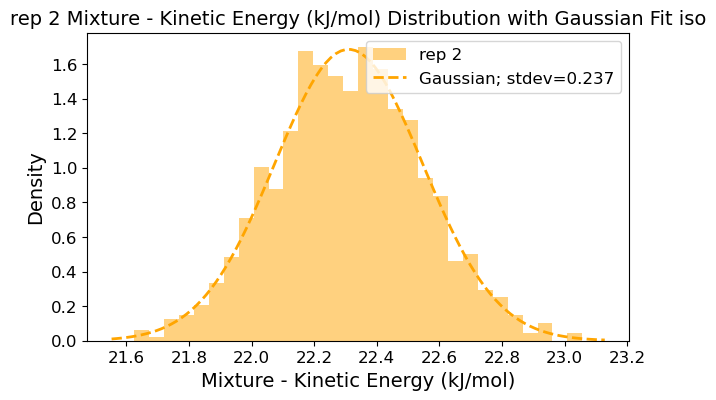

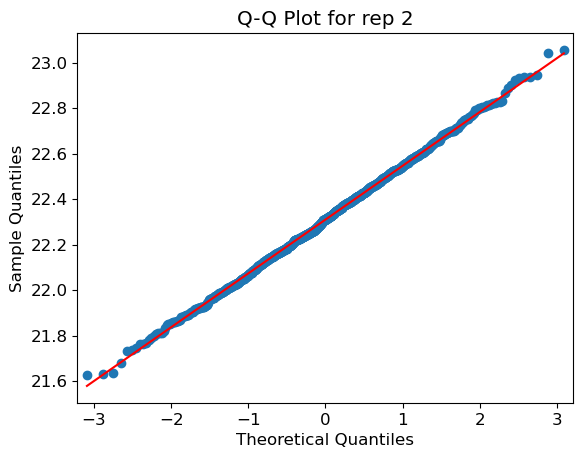

mean: 22.294935736988183
stdv: 0.24412507288787386
Shapiro Statistics=0.998, p=4.171e-01
Shapiro: Sample looks Gaussian (fail to reject H0)
Anderson-Darling Statistic: 0.512
Anderson-Darling: 15.000: 0.574, data looks normal (fail to reject H0)
Anderson-Darling: 10.000: 0.653, data looks normal (fail to reject H0)
Anderson-Darling: 5.000: 0.784, data looks normal (fail to reject H0)
Anderson-Darling: 2.500: 0.914, data looks normal (fail to reject H0)
Anderson-Darling: 1.000: 1.088, data looks normal (fail to reject H0)
Kolmogorov-Smirnov Statistics=0.020, p=8.171e-01
Kolmogorov-Smirnov: Sample looks Gaussian (fail to reject H0)


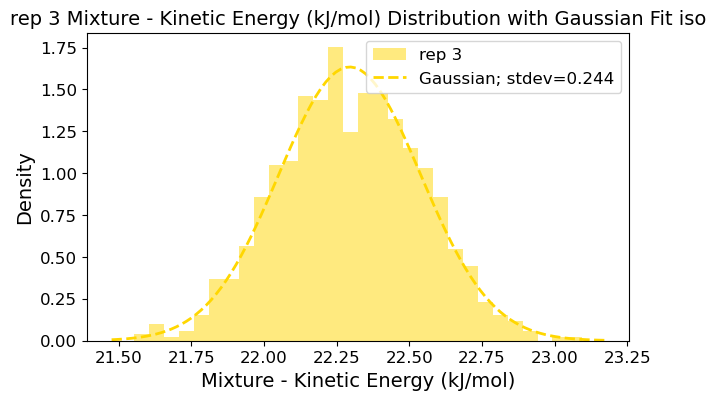

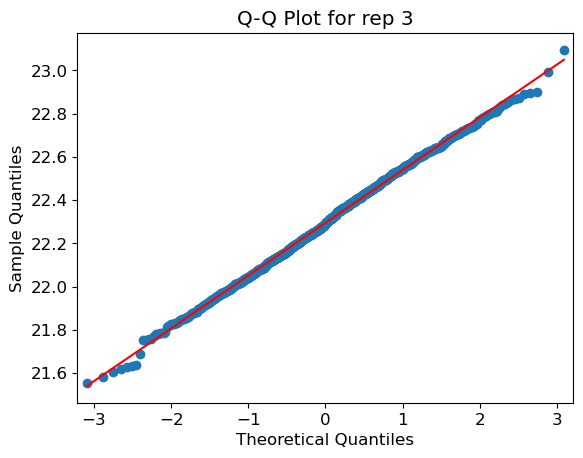

In [74]:
dists_indiv_energy(KE_ts_mix,'Mixture - Kinetic Energy (kJ/mol)')

### OBSERVABLES - MIXTURE

In [30]:
mixout=extract_data('6439_extract_observable_mixture_output.json')
mix_prod=extract_data('6439_production_simulation_mixture_output.json')

mixout_values=[]
mixout_errors=[]
mixout_totpts=[]
mixout_uncorrpts=[]
mixout_statineff=[]
mixout_equilindex=[]

for key, mr in mixout.items():
    if 'value' in key:
        print(f"{key}:{mr['value']}")
        mixout_values.append(mr['value'])
    elif 'error' in key:
        print(f"{key}:{mr['value']}")
        mixout_errors.append(mr['value'])
    elif 'n_total_points' in key:
        # print(f"{key}:{mr}")
        mixout_totpts.append(mr)
    elif 'n_uncorrelated_points' in key:
        # print(f"{key}:{mr}")
        mixout_uncorrpts.append(mr)
    elif 'statistical_inefficiency' in key:
        # print(f"{key}:{mr}")
        mixout_statineff.append(mr)
    elif 'equilibration_index' in key:
        # print(f"{key}:{mr}")
        mixout_equilindex.append(mr)

with open(f'mixture_output_{file_posfix}.txt', 'w') as file:
    file.write(f'Mixture Values list: {mixout_values} \n')
    file.write(f'Mixture Errors list: {mixout_errors} \n')
    file.write(f'Mixture Total points list: {mixout_totpts} \n')
    file.write(f'Mixture Uncorrelated points list: {mixout_uncorrpts} \n')
    file.write(f'Mixture Statistical inefficiency list: {mixout_statineff} \n')
    file.write(f'Mixture Equilibration index list: {mixout_equilindex} \n')

Data from iso_r1 loaded successfully into dataframe: iso_r1
Data from iso_r2 loaded successfully into dataframe: iso_r2
Data from iso_r3 loaded successfully into dataframe: iso_r3
Data from iso_r1 loaded successfully into dataframe: iso_r1
Data from iso_r2 loaded successfully into dataframe: iso_r2
Data from iso_r3 loaded successfully into dataframe: iso_r3
value_r1:-20.834618015439926
error_r1:0.017443118211388
value_r2:-20.743974845929227
error_r2:0.024205884481817003
value_r3:-20.825040711572168
error_r3:0.021481574016191003


In [31]:
mix_prod_enthalpy=[]

for key, mr in mix_prod.items():
    if 'production_data' in key:
        flat_mr = [item[0] for item in mr]
        # print(f"{key}:{flat_mr}")
        mix_prod_enthalpy.append(flat_mr)

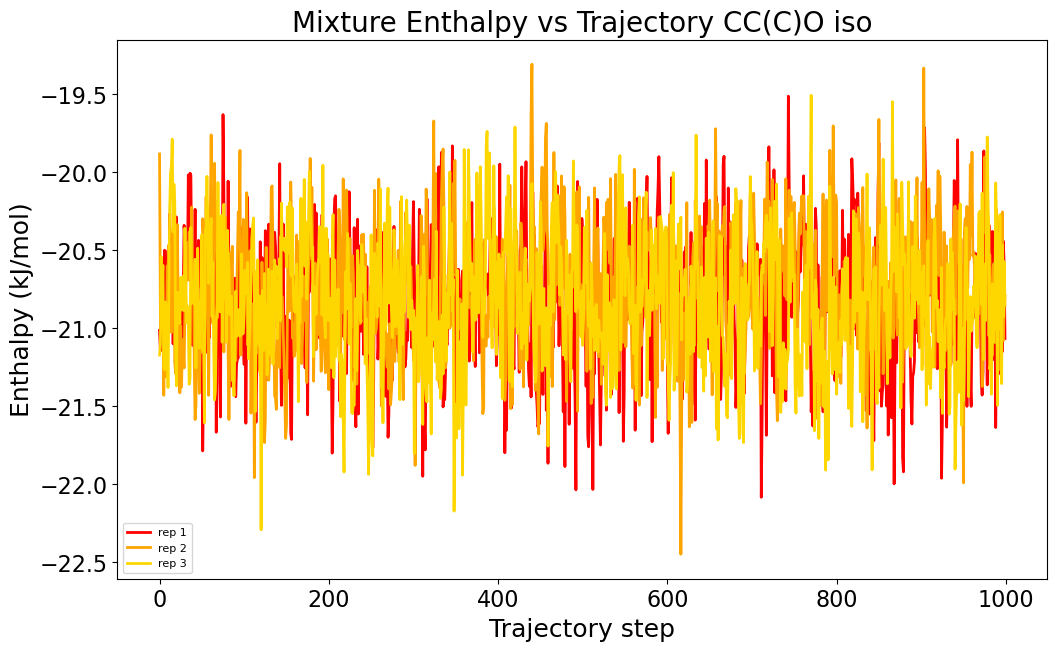

In [32]:
timeseries_overlap(mix_prod_enthalpy,'Mixture')

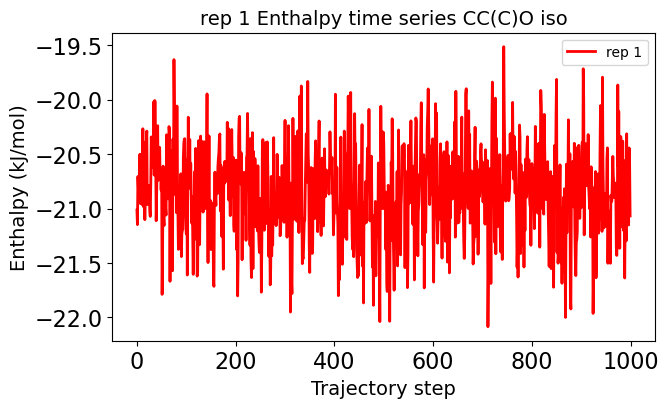

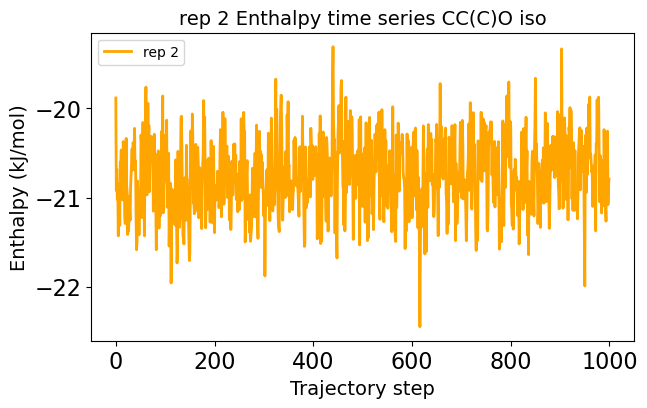

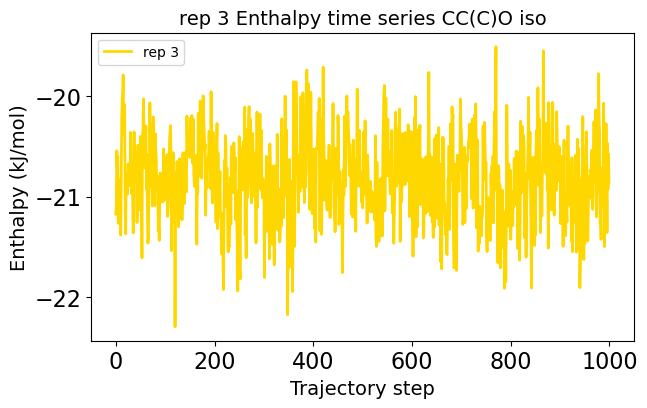

In [33]:
timeseriesplot(mix_prod_enthalpy)

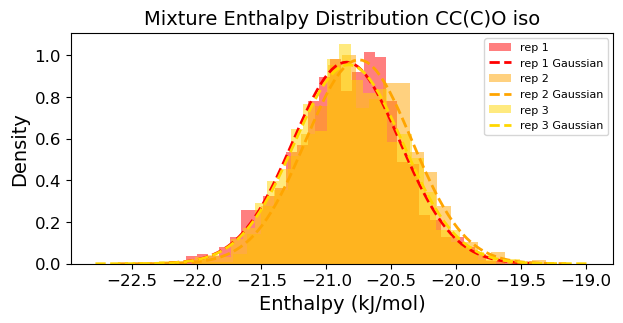

In [34]:
dists_allinone(mix_prod_enthalpy)

mean: -20.845428262409165
stdv: 0.41260069872079813
Shapiro Statistics=0.998, p=0.208
Shapiro: Sample looks Gaussian (fail to reject H0)
Anderson-Darling Statistic: 0.770
Anderson-Darling: 15.000: 0.574, data does not look normal (reject H0)
Anderson-Darling: 10.000: 0.653, data does not look normal (reject H0)
Anderson-Darling: 5.000: 0.784, data looks normal (fail to reject H0)
Anderson-Darling: 2.500: 0.914, data looks normal (fail to reject H0)
Anderson-Darling: 1.000: 1.088, data looks normal (fail to reject H0)
Kolmogorov-Smirnov Statistics=0.024, p=0.594
Kolmogorov-Smirnov: Sample looks Gaussian (fail to reject H0)


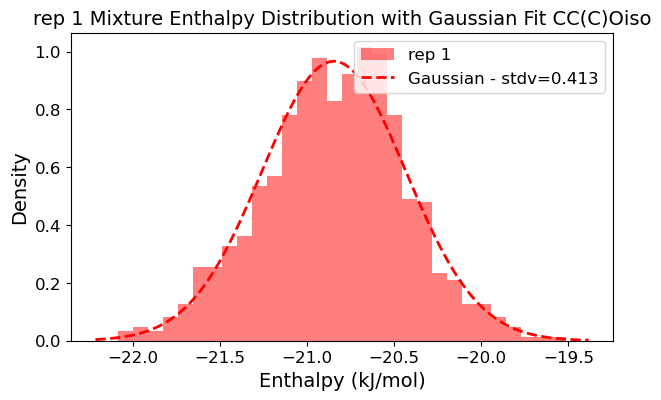

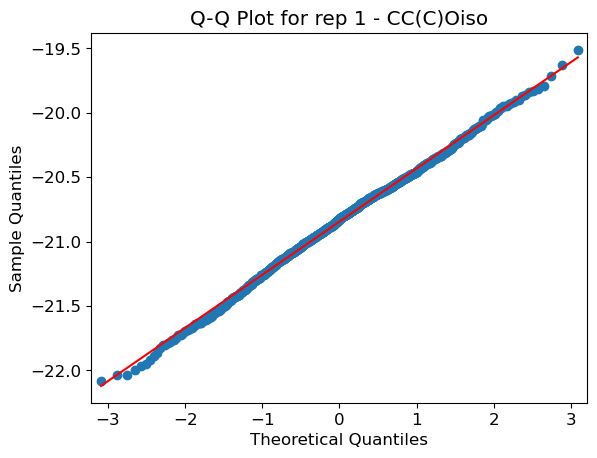

mean: -20.749672782789112
stdv: 0.40780427451322593
Shapiro Statistics=0.997, p=0.100
Shapiro: Sample looks Gaussian (fail to reject H0)
Anderson-Darling Statistic: 0.641
Anderson-Darling: 15.000: 0.574, data does not look normal (reject H0)
Anderson-Darling: 10.000: 0.653, data looks normal (fail to reject H0)
Anderson-Darling: 5.000: 0.784, data looks normal (fail to reject H0)
Anderson-Darling: 2.500: 0.914, data looks normal (fail to reject H0)
Anderson-Darling: 1.000: 1.088, data looks normal (fail to reject H0)
Kolmogorov-Smirnov Statistics=0.026, p=0.508
Kolmogorov-Smirnov: Sample looks Gaussian (fail to reject H0)


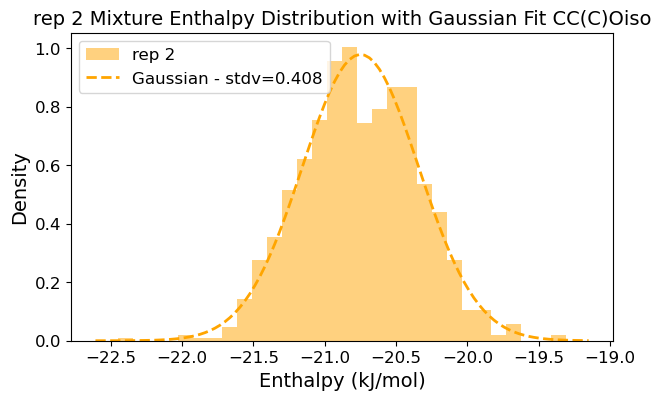

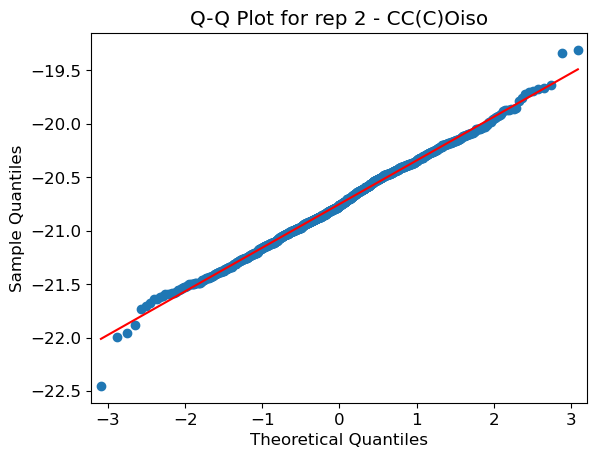

mean: -20.827623784336645
stdv: 0.41791323582566164
Shapiro Statistics=0.999, p=0.953
Shapiro: Sample looks Gaussian (fail to reject H0)
Anderson-Darling Statistic: 0.219
Anderson-Darling: 15.000: 0.574, data looks normal (fail to reject H0)
Anderson-Darling: 10.000: 0.653, data looks normal (fail to reject H0)
Anderson-Darling: 5.000: 0.784, data looks normal (fail to reject H0)
Anderson-Darling: 2.500: 0.914, data looks normal (fail to reject H0)
Anderson-Darling: 1.000: 1.088, data looks normal (fail to reject H0)
Kolmogorov-Smirnov Statistics=0.018, p=0.910
Kolmogorov-Smirnov: Sample looks Gaussian (fail to reject H0)


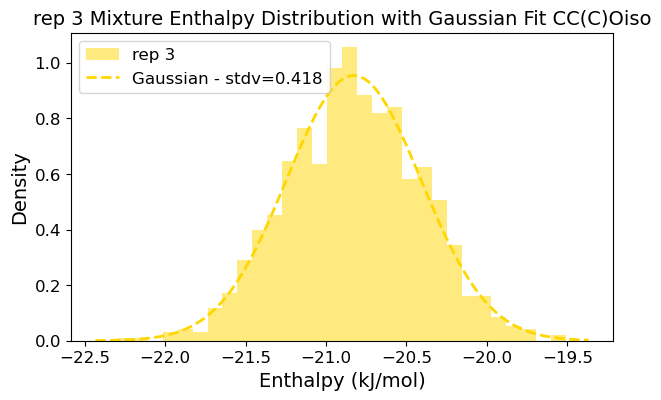

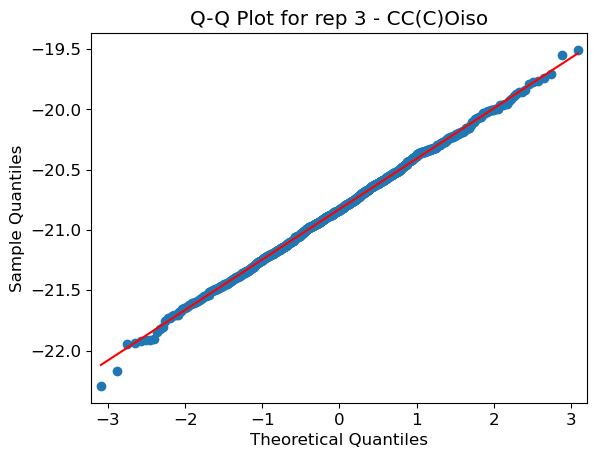

In [78]:
dists_indiv(mix_prod_enthalpy,'Mixture')

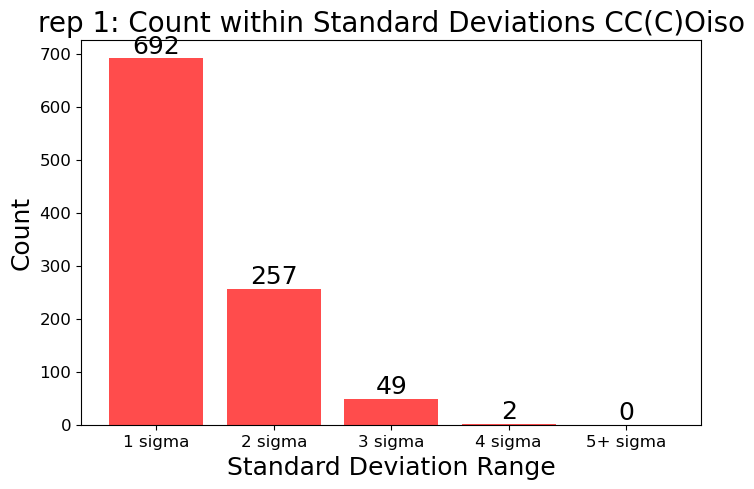

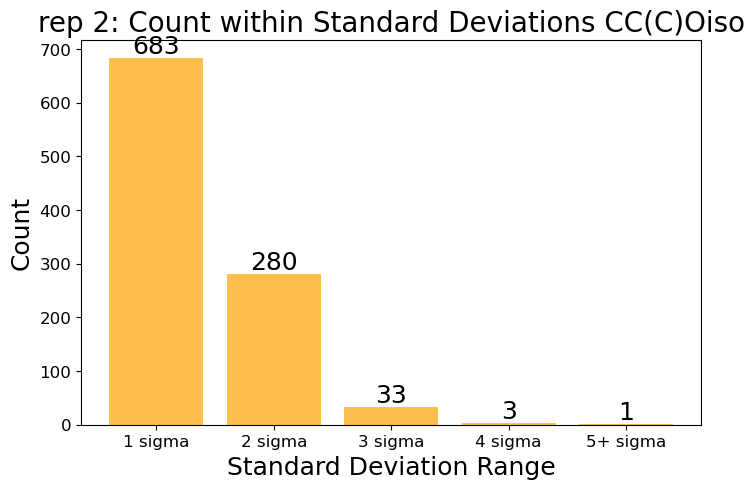

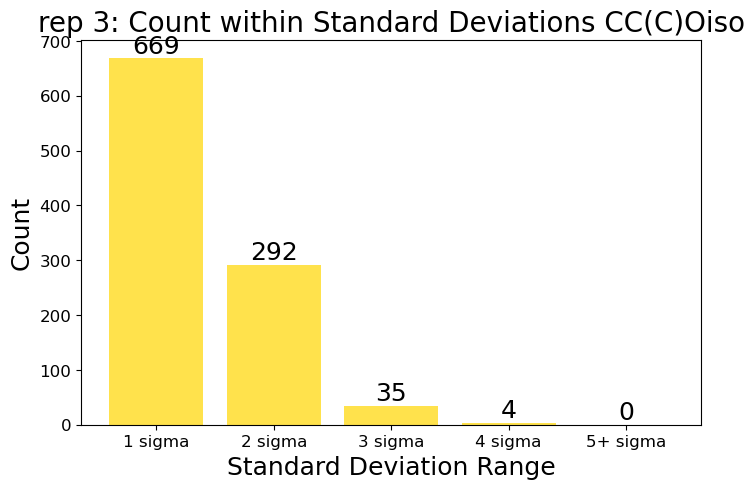

In [36]:
sigma_counts(mix_prod_enthalpy)

In [37]:
mix_filter={}
for i in range(replicate_number):
    mix_filter[i] = remove_outliers(mix_prod_enthalpy[i])

filtered_results(mix_filter)

Number of data points removed: 2
Number of data points removed: 4
Number of data points removed: 4
Means of filtered data for each replicate: [-20.84552199 -20.74958847 -20.8274105 ]
Standard deviation of the means: 0.04161668417168291


## COMPONENT 1

### ENERGY STATS - COMPONENT 1

In [38]:
# eq_stats_c1=extract_data('openmm_statistics_eqc1.csv')

# eqc1_stats={}
# for i in range(len(subdirs)):
#     eqc1_stats[i] = eq_stats_c1[f'df_stats_r{i+1}']

# eqc1_boxvol=[]
# eqc1_dens=[]

# for key, value_list in eqc1_stats.items():
#     eqc1_boxvol.append(value_list['Box Volume (nm^3)'])
#     eqc1_dens.append(value_list['Density (g/mL)'])


# eqc1_boxvol=np.array(eqc1_boxvol)
# eqc1_dens=np.array(eqc1_dens)

# starteq_ps100_vol=[]
# for i in range(len(eqc1_boxvol)):
#     first10=eqc1_boxvol[i][:10]
#     starteq_ps100_vol.append(first10.mean())
# print('Start of equilibration c1 VOLUME 100 ps average',starteq_ps100_vol)

# starteq_ps100_dens=[]
# for i in range(len(eqc1_dens)):
#     first10=eqc1_dens[i][:10]
#     starteq_ps100_dens.append(first10.mean())
# print('Start of equilibration c1 DENS 100 ps average',starteq_ps100_dens)
# print('Mean: ', np.mean(starteq_ps100_dens))


# endeq_ps100_vol=[]
# for i in range(len(eqc1_boxvol)):
#     last10=eqc1_boxvol[i][-10:]
#     endeq_ps100_vol.append(last10.mean())
# print('End of equilibration c1 VOLUME 100 ps average',endeq_ps100_vol)

# endeq_ps100_dens=[]
# for i in range(len(eqc1_dens)):
#     last10=eqc1_dens[i][-10:]
#     endeq_ps100_dens.append(last10.mean())
# print('End of equilibration c1 DENS 100 ps average',endeq_ps100_dens)
# print('Mean: ', np.mean(endeq_ps100_dens))

In [39]:
prod_stats_c1=extract_data('openmm_statistics_c1.csv')

prodc1_stats={}
for i in range(len(subdirs)):
    prodc1_stats[i] = prod_stats_c1[f'df_stats_r{i+1}']

prodc1_boxvol=[]
prodc1_dens=[]

for key, value_list in prodc1_stats.items():
    prodc1_boxvol.append(value_list['Box Volume (nm^3)'])
    prodc1_dens.append(value_list['Density (g/mL)'])


prodc1_boxvol=np.array(prodc1_boxvol)
prodc1_dens=np.array(prodc1_dens)

startprod_ps100_vol=[]
for i in range(len(prodc1_boxvol)):
    first25=prodc1_boxvol[i][:25]
    startprod_ps100_vol.append(first25.mean())
print('Start of production c1 VOLUME 100 ps average',startprod_ps100_vol)

startprod_ps100_dens=[]
for i in range(len(prodc1_dens)):
    first25=prodc1_dens[i][:25]
    startprod_ps100_dens.append(first25.mean())
print('Start of production c1 DENS 100 ps average',startprod_ps100_dens)



endprod_ps100_vol=[]
for i in range(len(prodc1_boxvol)):
    last25=prodc1_boxvol[i][-25:]
    endprod_ps100_vol.append(last25.mean())
print('End of production c1 VOLUME 100 ps average',endprod_ps100_vol)

endprod_ps100_dens=[]
for i in range(len(prodc1_dens)):
    last25=prodc1_dens[i][-25:]
    endprod_ps100_dens.append(last25.mean())
print('End of production c1 DENS 100 ps average',endprod_ps100_dens)
print('Mean: ', np.mean(endprod_ps100_dens))

Data from iso_r1 loaded successfully into dataframe: iso_r1
Data from iso_r2 loaded successfully into dataframe: iso_r2
Data from iso_r3 loaded successfully into dataframe: iso_r3
Start of production c1 VOLUME 100 ps average [30.82213328759449, 30.764482009106295, 30.79812942059798]
Start of production c1 DENS 100 ps average [0.9706680950599071, 0.9724910598396037, 0.9714339280495501]
End of production c1 VOLUME 100 ps average [30.861742941349103, 30.77725713507558, 30.789368738395165]
End of production c1 DENS 100 ps average [0.9694326864450713, 0.9720662936266851, 0.9716744456096031]
Mean:  0.9710578085604532


In [40]:
stats_c1=extract_data('openmm_statistics_c1.csv')

means_stats_c1={}
for i in range(len(subdirs)):
    means_stats_c1[i] = stats_c1[f'df_stats_r{i+1}'].mean()

PE_c1=[]
KE_c1=[]
TE_c1=[]
temp_c1=[]
bVol_c1=[]
dens_c1=[]

for key, value_list in means_stats_c1.items():
    # print(f'Key: {key}')
    # print(f'Values: {value_list}')
    PE_c1.append(value_list.iloc[1])
    KE_c1.append(value_list.iloc[2])
    TE_c1.append(value_list.iloc[3])
    temp_c1.append(value_list.iloc[4])
    bVol_c1.append(value_list.iloc[5])
    dens_c1.append(value_list.iloc[6])

## Calculate means and MSE
PE_mean=np.array(PE_c1).mean()
PE_std=np.array(PE_c1).std(ddof=1)
PE_err=PE_std/np.sqrt(len(PE_c1))
print(f'Hmix replicates, Potential Energy (kJ/mol): {PE_mean:.3f} +/- {PE_err:.3f}')

KE_mean=np.array(KE_c1).mean()
KE_std=np.array(KE_c1).std(ddof=1)
KE_err=KE_std/np.sqrt(len(KE_c1))
print(f'Hmix replicates, Kinetic Energy (kJ/mol): {KE_mean:.3f} +/- {KE_err:.3f}')

TE_mean=np.array(TE_c1).mean()
TE_std=np.array(TE_c1).std(ddof=1)
TE_err=TE_std/np.sqrt(len(TE_c1))
print(f'Hmix replicates, Total Energy (kJ/mol): {TE_mean:.3f} +/- {TE_err:.3f}')

Temp_mean=np.array(temp_c1).mean()
Temp_std=np.array(temp_c1).std(ddof=1)
Temp_err=Temp_std/np.sqrt(len(temp_c1))
print(f'Hmix replicates, Temperature (K): {Temp_mean:.3f} +/- {Temp_err:.3f}')

bVol_mean=np.array(bVol_c1).mean()
bVol_std=np.array(bVol_c1).std(ddof=1)
bVol_err=bVol_std/np.sqrt(len(bVol_c1))
print(f'Hmix replicates, Box Volume (nm^3): {bVol_mean:.3f} +/- {bVol_err:.3f}')

dens_mean=np.array(dens_c1).mean()
dens_std=np.array(dens_c1).std(ddof=1)
dens_err=dens_std/np.sqrt(len(dens_c1))
print(f'Hmix replicates, Density (g/mL): {dens_mean:.3f} +/- {dens_err:.3f}')

with open(f'c1_stats_{file_posfix}.txt', 'w') as file:
    file.write(f'Molecule number: {molnumb} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Potential Energy (kJ/mol): {PE_mean:.3f} +/- {PE_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Kinetic Energy (kJ/mol): {KE_mean:.3f} +/- {KE_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Total Energy (kJ/mol): {TE_mean:.3f} +/- {TE_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Temperature (K): {Temp_mean:.3f} +/- {Temp_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Box Volume (nm^3): {bVol_mean:.3f} +/- {bVol_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Density (g/mL): {dens_mean:.3f} +/- {dens_err:.3f} \n')

Data from iso_r1 loaded successfully into dataframe: iso_r1
Data from iso_r2 loaded successfully into dataframe: iso_r2
Data from iso_r3 loaded successfully into dataframe: iso_r3
Hmix replicates, Potential Energy (kJ/mol): -39283.078 +/- 1.334
Hmix replicates, Kinetic Energy (kJ/mol): 7818.009 +/- 1.327
Hmix replicates, Total Energy (kJ/mol): -31465.068 +/- 2.547
Hmix replicates, Temperature (K): 313.430 +/- 0.053
Hmix replicates, Box Volume (nm^3): 30.780 +/- 0.010
Hmix replicates, Density (g/mL): 0.972 +/- 0.000


In [41]:
PE_ts_c1={}
KE_ts_c1={}
TE_ts_c1={}
temp_ts_c1={}
bvol_ts_c1={}
dens_ts_c1={}
for i in range(replicate_number):
    PE_ts_c1[i]=stats_c1[f'df_stats_r{i+1}']['Potential Energy (kJ/mole)']
    KE_ts_c1[i]=stats_c1[f'df_stats_r{i+1}']['Kinetic Energy (kJ/mole)']
    TE_ts_c1[i]=stats_c1[f'df_stats_r{i+1}']['Total Energy (kJ/mole)']
    temp_ts_c1[i]=stats_c1[f'df_stats_r{i+1}']['Temperature (K)']
    bvol_ts_c1[i]=stats_c1[f'df_stats_r{i+1}']['Box Volume (nm^3)']
    dens_ts_c1[i]=stats_c1[f'df_stats_r{i+1}']['Density (g/mL)']

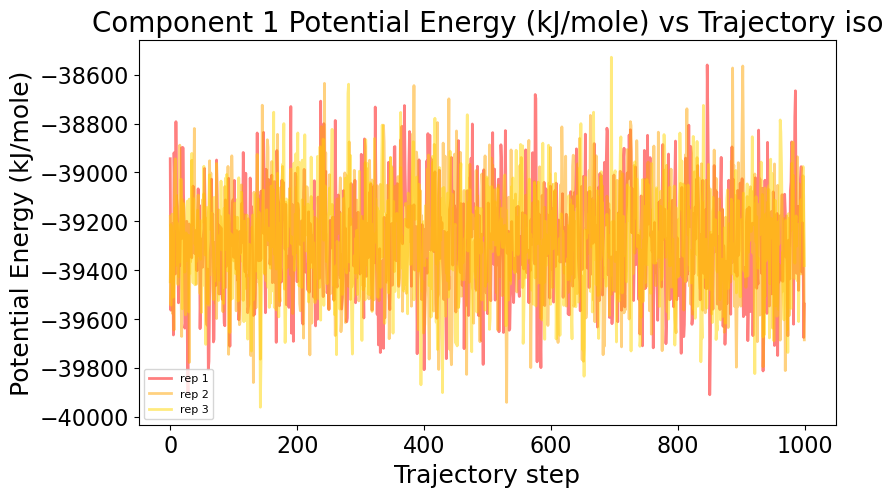

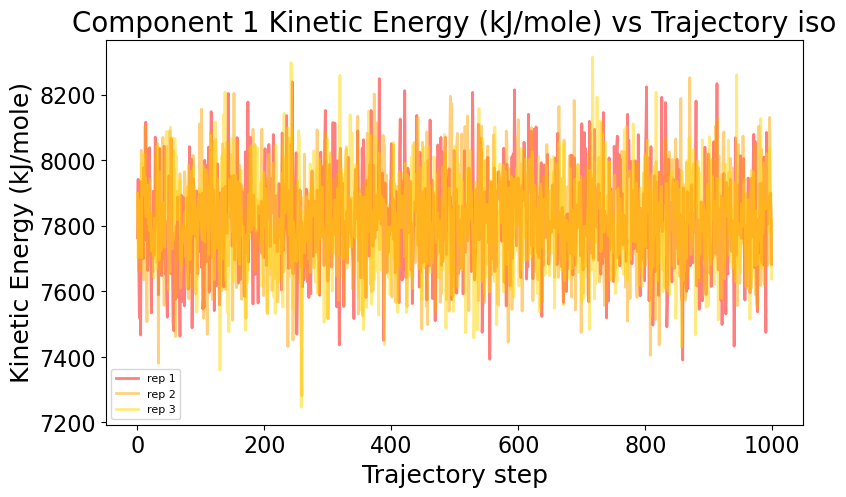

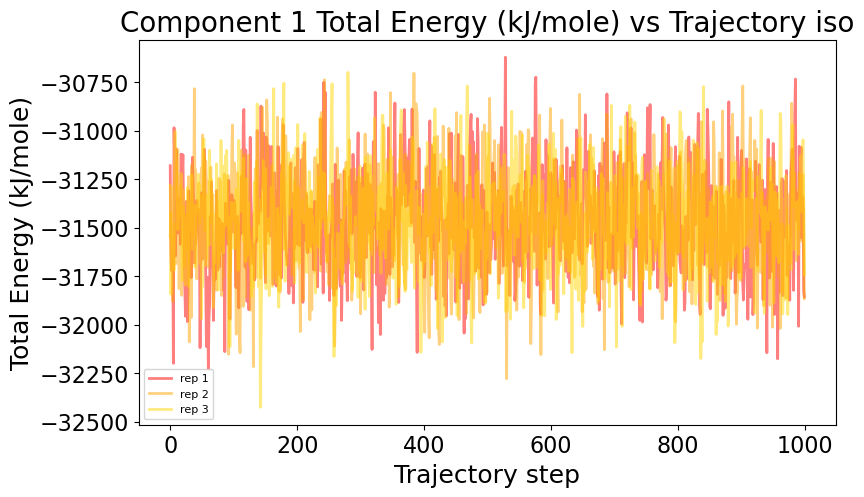

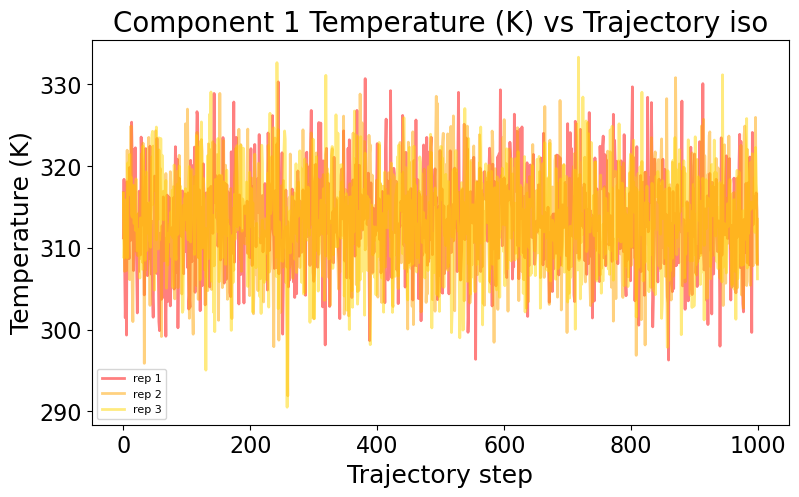

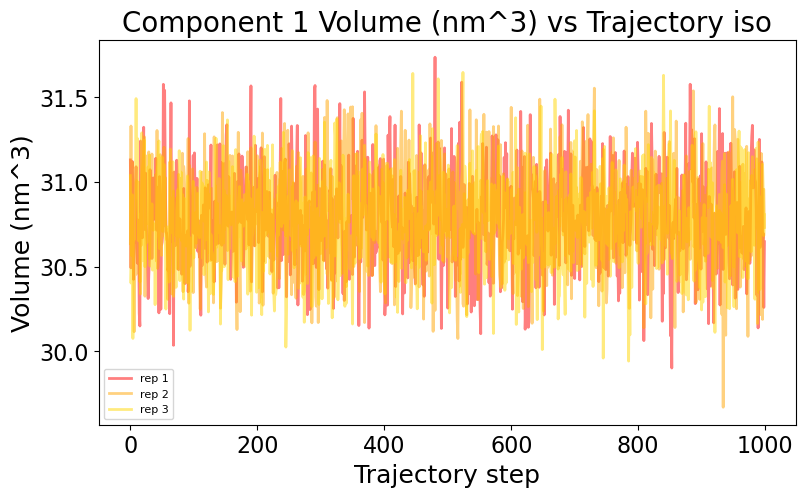

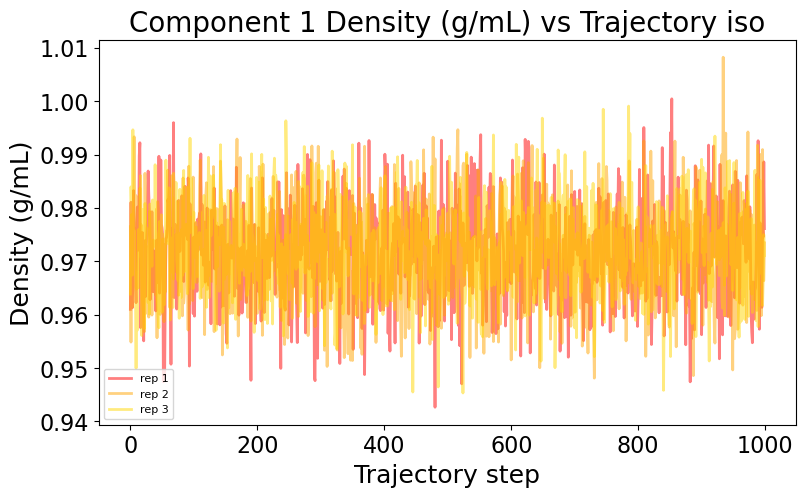

In [42]:
ts_energy(PE_ts_c1,'Potential Energy (kJ/mole)','Component 1')
ts_energy(KE_ts_c1,'Kinetic Energy (kJ/mole)','Component 1')
ts_energy(TE_ts_c1,'Total Energy (kJ/mole)','Component 1')
ts_energy(temp_ts_c1,'Temperature (K)','Component 1')
ts_energy(bvol_ts_c1,'Volume (nm^3)', 'Component 1')
ts_energy(dens_ts_c1,'Density (g/mL)', 'Component 1')

### OBSERVABLES - COMPONENT 1

In [43]:
comp1=extract_data('6728_extract_observable_component_1_output.json')
comp1_prod=extract_data('6728_production_simulation_component_1_output.json')

comp1_values=[]
comp1_errors=[]
comp1_totpts=[]
comp1_uncorrpts=[]
comp1_statineff=[]
comp1_equilindex=[]

for key, mr in comp1.items():
    if 'value' in key:
        # print(f"{key}:{mr['value']}")
        comp1_values.append(mr['value'])
    elif 'error' in key:
        # print(f"{key}:{mr['value']}")
        comp1_errors.append(mr['value'])
    elif 'n_total_points' in key:
        # print(f"{key}:{mr}")
        comp1_totpts.append(mr)
    elif 'n_uncorrelated_points' in key:
        # print(f"{key}:{mr}")
        comp1_uncorrpts.append(mr)
    elif 'statistical_inefficiency' in key:
        # print(f"{key}:{mr}")
        comp1_statineff.append(mr)
    elif 'equilibration_index' in key:
        # print(f"{key}:{mr}")
        comp1_equilindex.append(mr)

with open(f'Component1_output_{file_posfix}.txt', 'w') as file:
    file.write(f'Component1 Values list: {comp1_values} \n')
    file.write(f'Component1 Errors list: {comp1_errors} \n')
    file.write(f'Component1 Total points list: {comp1_totpts} \n')
    file.write(f'Component1 Uncorrelated points list: {comp1_uncorrpts} \n')
    file.write(f'Component1 Statistical inefficiency list: {comp1_statineff} \n')
    file.write(f'Component1 Equilibration index list: {comp1_equilindex} \n')

Data from iso_r1 loaded successfully into dataframe: iso_r1
Data from iso_r2 loaded successfully into dataframe: iso_r2
Data from iso_r3 loaded successfully into dataframe: iso_r3
Data from iso_r1 loaded successfully into dataframe: iso_r1
Data from iso_r2 loaded successfully into dataframe: iso_r2
Data from iso_r3 loaded successfully into dataframe: iso_r3


In [44]:
c1_prod_enthalpy=[]

for key, mr in comp1_prod.items():
    if 'production_data' in key:
        flat_mr = [item[0] for item in mr]
        # print(f"{key}:{flat_mr}")
        c1_prod_enthalpy.append(flat_mr)

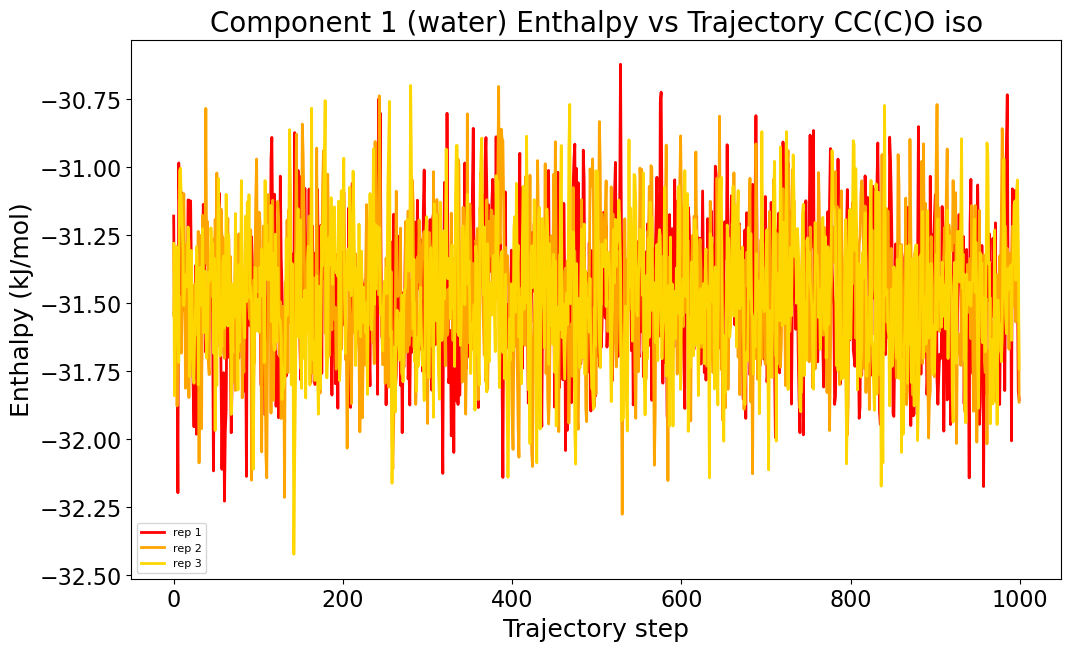

In [45]:
timeseries_overlap(c1_prod_enthalpy, 'Component 1 (water)')

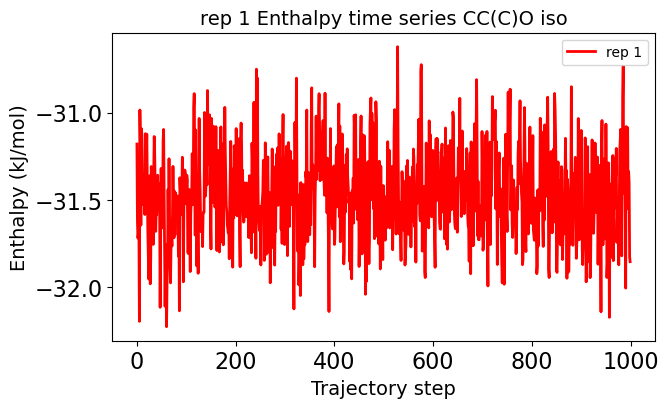

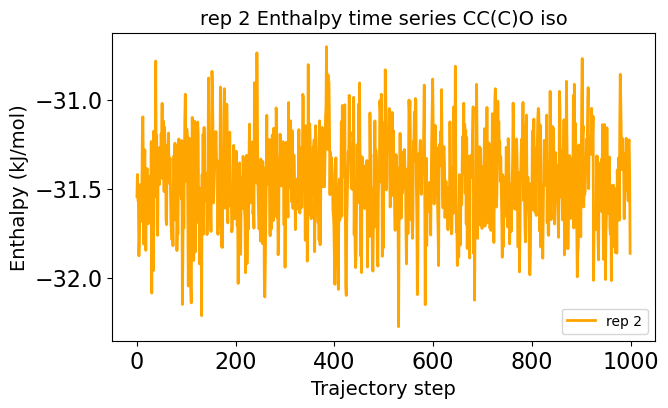

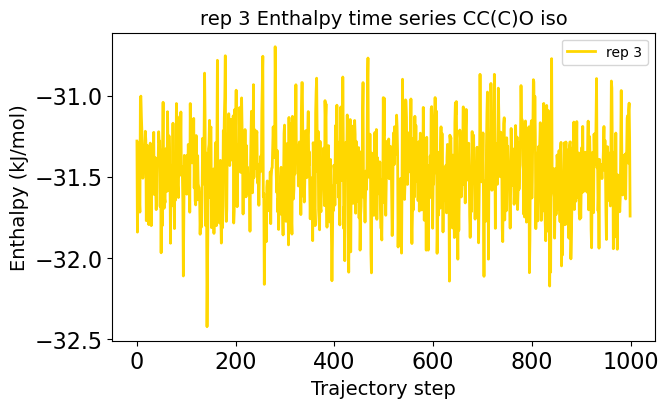

In [46]:
timeseriesplot(c1_prod_enthalpy)

mean: -31.46571894241717
stdv: 0.261463636620164
Shapiro Statistics=0.998, p=0.417
Shapiro: Sample looks Gaussian (fail to reject H0)
Anderson-Darling Statistic: 0.441
Anderson-Darling: 15.000: 0.574, data looks normal (fail to reject H0)
Anderson-Darling: 10.000: 0.653, data looks normal (fail to reject H0)
Anderson-Darling: 5.000: 0.784, data looks normal (fail to reject H0)
Anderson-Darling: 2.500: 0.914, data looks normal (fail to reject H0)
Anderson-Darling: 1.000: 1.088, data looks normal (fail to reject H0)
Kolmogorov-Smirnov Statistics=0.021, p=0.754
Kolmogorov-Smirnov: Sample looks Gaussian (fail to reject H0)


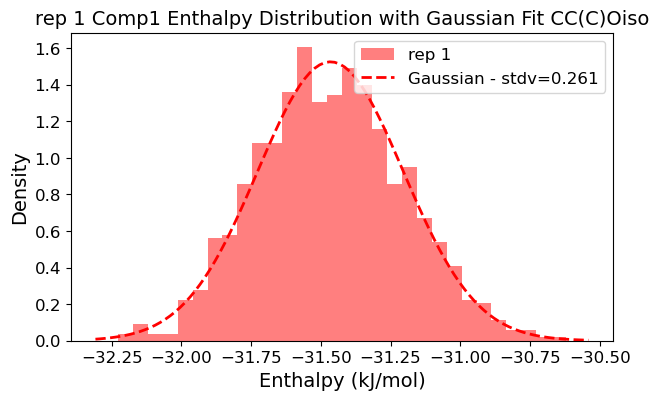

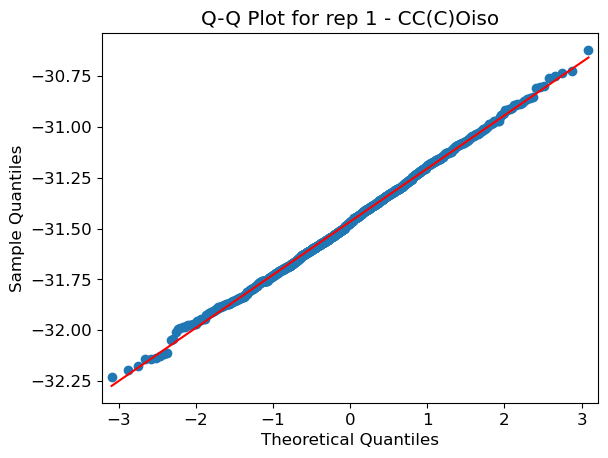

mean: -31.45810095204149
stdv: 0.2571368241570354
Shapiro Statistics=0.999, p=0.890
Shapiro: Sample looks Gaussian (fail to reject H0)
Anderson-Darling Statistic: 0.218
Anderson-Darling: 15.000: 0.574, data looks normal (fail to reject H0)
Anderson-Darling: 10.000: 0.653, data looks normal (fail to reject H0)
Anderson-Darling: 5.000: 0.784, data looks normal (fail to reject H0)
Anderson-Darling: 2.500: 0.914, data looks normal (fail to reject H0)
Anderson-Darling: 1.000: 1.088, data looks normal (fail to reject H0)
Kolmogorov-Smirnov Statistics=0.016, p=0.953
Kolmogorov-Smirnov: Sample looks Gaussian (fail to reject H0)


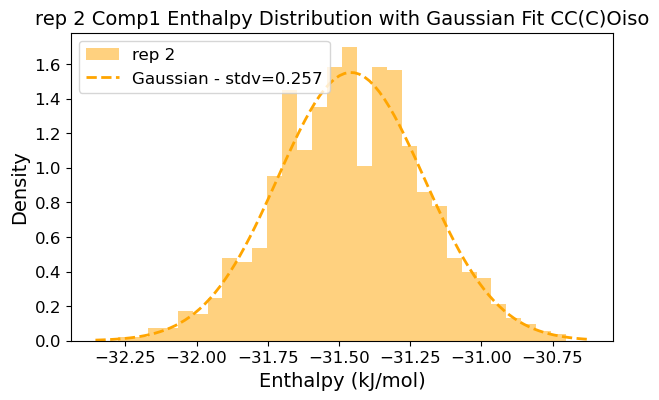

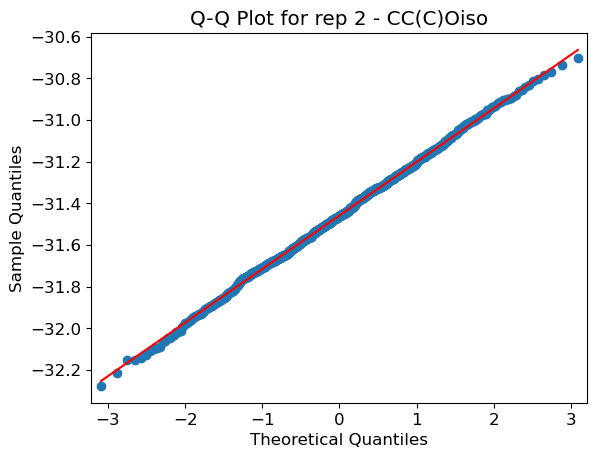

mean: -31.46576791914796
stdv: 0.24921662879005113
Shapiro Statistics=0.999, p=0.797
Shapiro: Sample looks Gaussian (fail to reject H0)
Anderson-Darling Statistic: 0.196
Anderson-Darling: 15.000: 0.574, data looks normal (fail to reject H0)
Anderson-Darling: 10.000: 0.653, data looks normal (fail to reject H0)
Anderson-Darling: 5.000: 0.784, data looks normal (fail to reject H0)
Anderson-Darling: 2.500: 0.914, data looks normal (fail to reject H0)
Anderson-Darling: 1.000: 1.088, data looks normal (fail to reject H0)
Kolmogorov-Smirnov Statistics=0.014, p=0.987
Kolmogorov-Smirnov: Sample looks Gaussian (fail to reject H0)


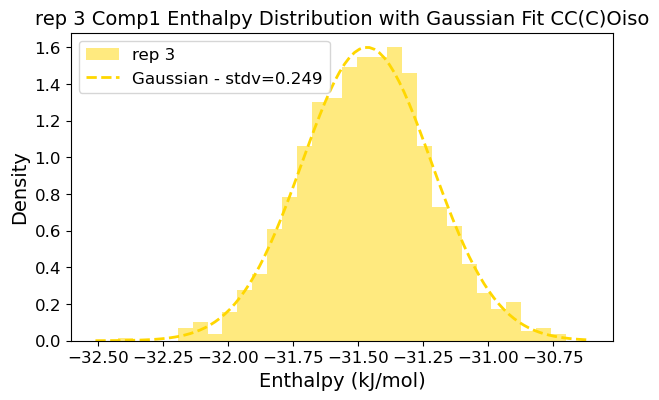

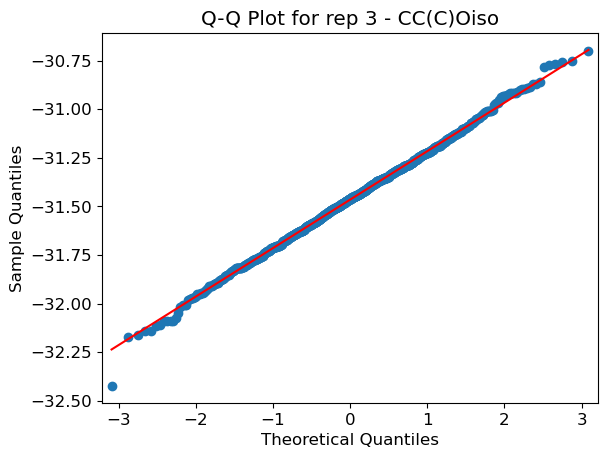

In [79]:
dists_indiv(c1_prod_enthalpy,'Comp1')

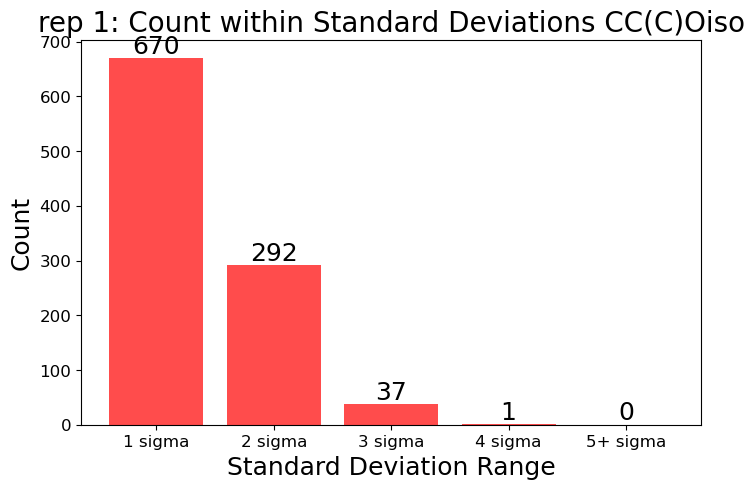

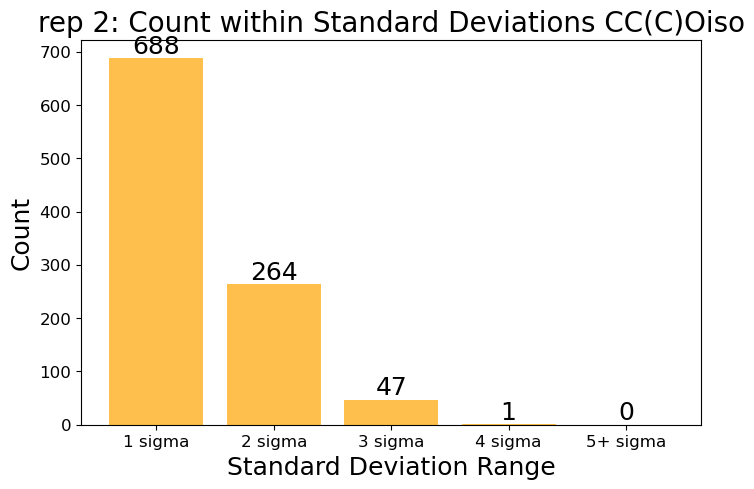

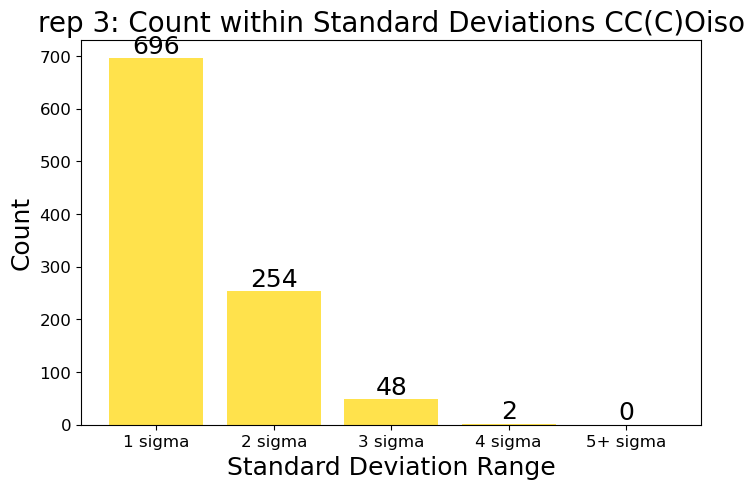

In [48]:
sigma_counts(c1_prod_enthalpy)

In [49]:
# c1_filter={}
# for i in range(6):
#     c1_filter[i] = remove_outliers(c1_prod_enthalpy[i])

# filtered_results(c1_filter)

## COMPONENT 0

### ENERGY STATS - COMPONENT 0

In [50]:
# eq_stats_c0=extract_data('openmm_statistics_eqc0.csv')

# eqc0_stats={}
# for i in range(len(subdirs)):
#     eqc0_stats[i] = eq_stats_c0[f'df_stats_r{i+1}']

# eqc0_boxvol=[]
# eqc0_dens=[]

# for key, value_list in eqc0_stats.items():
#     eqc0_boxvol.append(value_list['Box Volume (nm^3)'])
#     eqc0_dens.append(value_list['Density (g/mL)'])


# eqc0_boxvol=np.array(eqc0_boxvol)
# eqc0_dens=np.array(eqc0_dens)

# starteq_ps100_vol=[]
# for i in range(len(eqc0_boxvol)):
#     first10=eqc0_boxvol[i][:10]
#     starteq_ps100_vol.append(first10.mean())
# print('Start of equilibration c0 VOLUME 100 ps average',starteq_ps100_vol)

# starteq_ps100_dens=[]
# for i in range(len(eqc0_dens)):
#     first10=eqc0_dens[i][:10]
#     starteq_ps100_dens.append(first10.mean())
# print('Start of equilibration c0 DENS 100 ps average',starteq_ps100_dens)



# endeq_ps100_vol=[]
# for i in range(len(eqc0_boxvol)):
#     last10=eqc0_boxvol[i][-10:]
#     endeq_ps100_vol.append(last10.mean())
# print('End of equilibration c0 VOLUME 100 ps average',endeq_ps100_vol)

# endeq_ps100_dens=[]
# for i in range(len(eqc0_dens)):
#     last10=eqc0_dens[i][-10:]
#     endeq_ps100_dens.append(last10.mean())
# print('End of equilibration c0 DENS 100 ps average',endeq_ps100_dens)

In [51]:
prod_stats_c0=extract_data('openmm_statistics_c0.csv')

prodc0_stats={}
for i in range(len(subdirs)):
    prodc0_stats[i] = prod_stats_c0[f'df_stats_r{i+1}']

prodc0_boxvol=[]
prodc0_dens=[]

for key, value_list in prodc0_stats.items():
    prodc0_boxvol.append(value_list['Box Volume (nm^3)'])
    prodc0_dens.append(value_list['Density (g/mL)'])


prodc0_boxvol=np.array(prodc0_boxvol)
prodc0_dens=np.array(prodc0_dens)

startprod_ps100_vol=[]
for i in range(len(prodc0_boxvol)):
    first25=prodc0_boxvol[i][:25]
    startprod_ps100_vol.append(first25.mean())
print('Start of production c0 VOLUME 100 ps average',startprod_ps100_vol)

startprod_ps100_dens=[]
for i in range(len(prodc0_dens)):
    first25=prodc0_dens[i][:25]
    startprod_ps100_dens.append(first25.mean())
print('Start of production c0 DENS 100 ps average',startprod_ps100_dens)



endprod_ps100_vol=[]
for i in range(len(prodc0_boxvol)):
    last25=prodc0_boxvol[i][-25:]
    endprod_ps100_vol.append(last25.mean())
print('End of production c0 VOLUME 100 ps average',endprod_ps100_vol)

endprod_ps100_dens=[]
for i in range(len(prodc0_dens)):
    last25=prodc0_dens[i][-25:]
    endprod_ps100_dens.append(last25.mean())
print('End of production c0 DENS 100 ps average',endprod_ps100_dens)

Data from iso_r1 loaded successfully into dataframe: iso_r1
Data from iso_r2 loaded successfully into dataframe: iso_r2
Data from iso_r3 loaded successfully into dataframe: iso_r3
Start of production c0 VOLUME 100 ps average [126.9959907084228, 127.09869287395377, 127.34083527592107]
Start of production c0 DENS 100 ps average [0.7857943426478784, 0.7851519396247635, 0.7836902805835264]
End of production c0 VOLUME 100 ps average [127.29313845156678, 127.10917513377721, 127.29139762256332]
End of production c0 DENS 100 ps average [0.7839824324341598, 0.7851014330977901, 0.7839726787076111]


In [52]:
stats_c0=extract_data('openmm_statistics_c0.csv')

means_stats_c0={}
for i in range(len(subdirs)):
    means_stats_c0[i] = stats_c0[f'df_stats_r{i+1}'].mean()

PE_c0=[]
KE_c0=[]
TE_c0=[]
temp_c0=[]
bVol_c0=[]
dens_c0=[]

for key, value_list in means_stats_c0.items():
    # print(f'Key: {key}')
    # print(f'Values: {value_list}')
    PE_c0.append(value_list.iloc[1])
    KE_c0.append(value_list.iloc[2])
    TE_c0.append(value_list.iloc[3])
    temp_c0.append(value_list.iloc[4])
    bVol_c0.append(value_list.iloc[5])
    dens_c0.append(value_list.iloc[6])

## Calculate means and MSE
PE_mean=np.array(PE_c0).mean()
PE_std=np.array(PE_c0).std(ddof=1)
PE_err=PE_std/np.sqrt(len(PE_c0))
print(f'Hmix replicates, Potential Energy (kJ/mol): {PE_mean:.3f} +/- {PE_err:.3f}')

KE_mean=np.array(KE_c0).mean()
KE_std=np.array(KE_c0).std(ddof=1)
KE_err=KE_std/np.sqrt(len(KE_c0))
print(f'Hmix replicates, Kinetic Energy (kJ/mol): {KE_mean:.3f} +/- {KE_err:.3f}')

TE_mean=np.array(TE_c0).mean()
TE_std=np.array(TE_c0).std(ddof=1)
TE_err=TE_std/np.sqrt(len(TE_c0))
print(f'Hmix replicates, Total Energy (kJ/mol): {TE_mean:.3f} +/- {TE_err:.3f}')

Temp_mean=np.array(temp_c0).mean()
Temp_std=np.array(temp_c0).std(ddof=1)
Temp_err=Temp_std/np.sqrt(len(temp_c0))
print(f'Hmix replicates, Temperature (K): {Temp_mean:.3f} +/- {Temp_err:.3f}')

bVol_mean=np.array(bVol_c0).mean()
bVol_std=np.array(bVol_c0).std(ddof=1)
bVol_err=bVol_std/np.sqrt(len(bVol_c0))
print(f'Hmix replicates, Box Volume (nm^3): {bVol_mean:.3f} +/- {bVol_err:.3f}')

dens_mean=np.array(dens_c0).mean()
dens_std=np.array(dens_c0).std(ddof=1)
dens_err=dens_std/np.sqrt(len(dens_c0))
print(f'Hmix replicates, Density (g/mL): {dens_mean:.3f} +/- {dens_err:.3f}')

with open(f'c0_stats_{file_posfix}.txt', 'w') as file:
    file.write(f'Molecule number: {molnumb} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Potential Energy (kJ/mol): {PE_mean:.3f} +/- {PE_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Kinetic Energy (kJ/mol): {KE_mean:.3f} +/- {KE_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Total Energy (kJ/mol): {TE_mean:.3f} +/- {TE_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Temperature (K): {Temp_mean:.3f} +/- {Temp_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Box Volume (nm^3): {bVol_mean:.3f} +/- {bVol_err:.3f} \n')
    file.write(f'Hmix {file_posfix} replicates, Average Density (g/mL): {dens_mean:.3f} +/- {dens_err:.3f} \n')

Data from iso_r1 loaded successfully into dataframe: iso_r1
Data from iso_r2 loaded successfully into dataframe: iso_r2
Data from iso_r3 loaded successfully into dataframe: iso_r3
Hmix replicates, Potential Energy (kJ/mol): -49236.415 +/- 6.477
Hmix replicates, Kinetic Energy (kJ/mol): 36480.383 +/- 0.931
Hmix replicates, Total Energy (kJ/mol): -12756.032 +/- 7.069
Hmix replicates, Temperature (K): 313.399 +/- 0.008
Hmix replicates, Box Volume (nm^3): 127.408 +/- 0.028
Hmix replicates, Density (g/mL): 0.783 +/- 0.000


In [53]:
PE_ts_c0={}
KE_ts_c0={}
TE_ts_c0={}
temp_ts_c0={}
bvol_ts_c0={}
dens_ts_c0={}
for i in range(replicate_number):
    PE_ts_c0[i]=stats_c0[f'df_stats_r{i+1}']['Potential Energy (kJ/mole)']
    KE_ts_c0[i]=stats_c0[f'df_stats_r{i+1}']['Kinetic Energy (kJ/mole)']
    TE_ts_c0[i]=stats_c0[f'df_stats_r{i+1}']['Total Energy (kJ/mole)']
    temp_ts_c0[i]=stats_c0[f'df_stats_r{i+1}']['Temperature (K)']
    bvol_ts_c0[i]=stats_c0[f'df_stats_r{i+1}']['Box Volume (nm^3)']
    dens_ts_c0[i]=stats_c0[f'df_stats_r{i+1}']['Density (g/mL)']


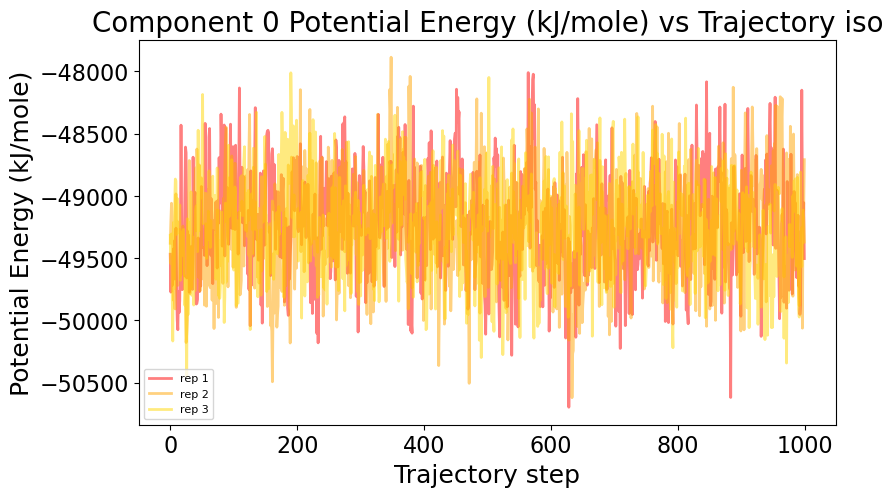

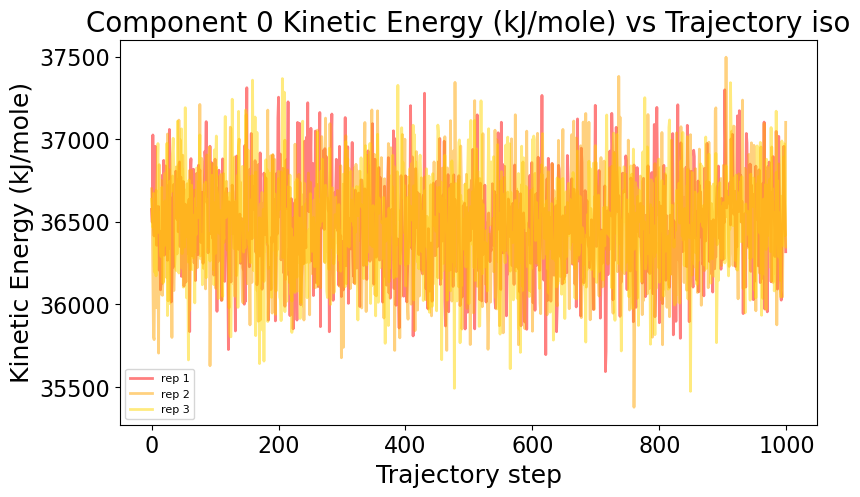

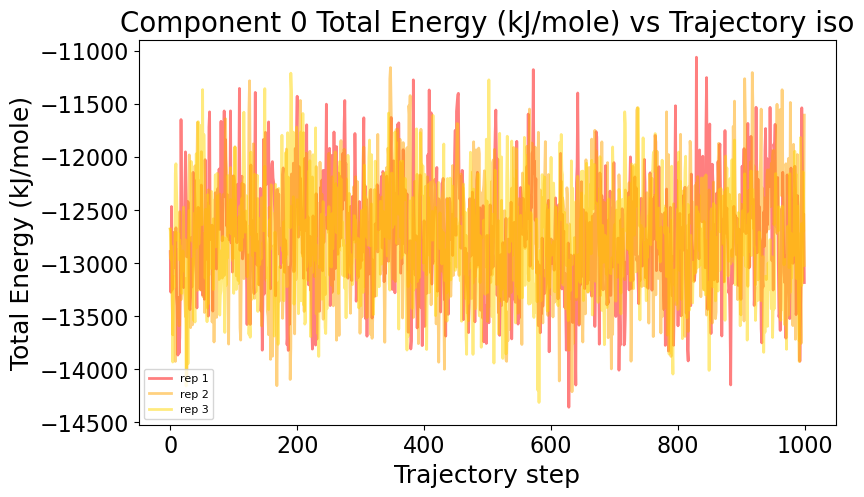

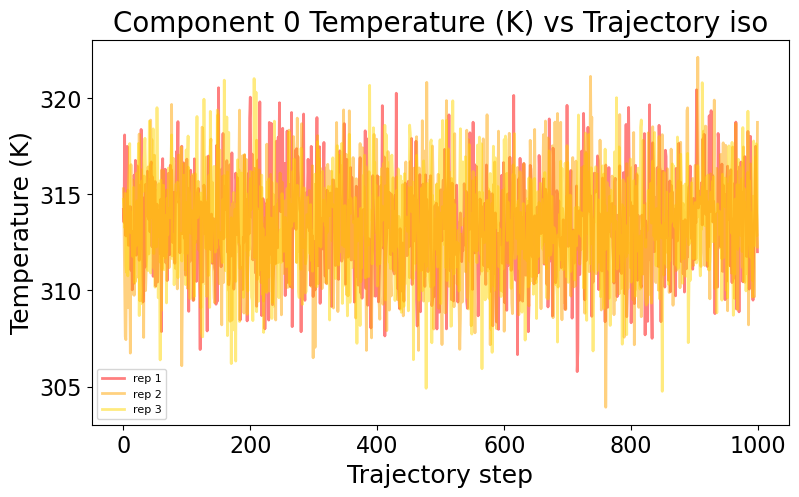

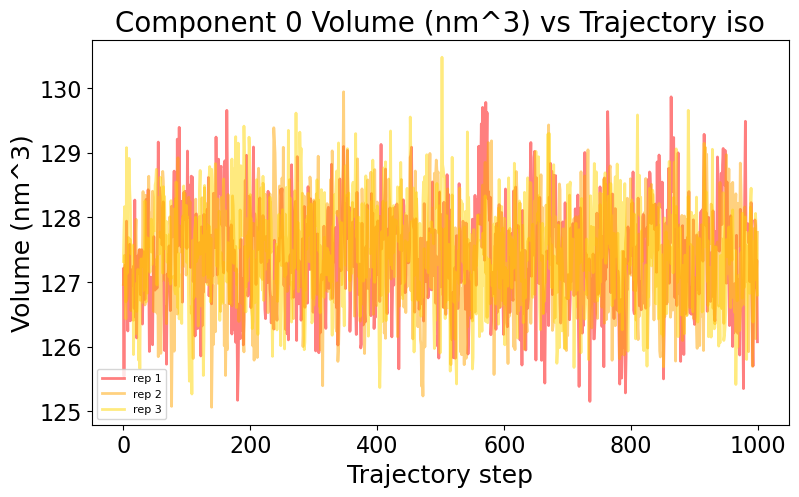

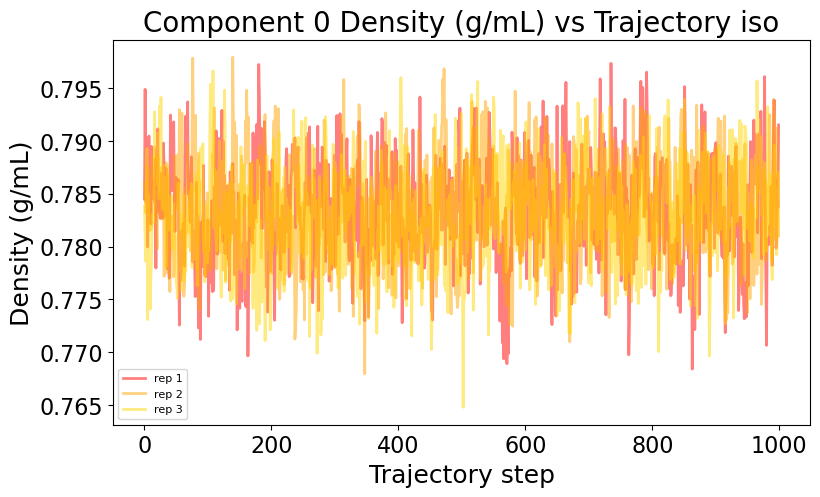

In [54]:
ts_energy(PE_ts_c0,'Potential Energy (kJ/mole)','Component 0')
ts_energy(KE_ts_c0,'Kinetic Energy (kJ/mole)','Component 0')
ts_energy(TE_ts_c0,'Total Energy (kJ/mole)','Component 0')
ts_energy(temp_ts_c0,'Temperature (K)','Component 0')
ts_energy(bvol_ts_c0,'Volume (nm^3)', 'Component 0')
ts_energy(dens_ts_c0,'Density (g/mL)', 'Component 0')

### OBSERVABLES - COMPONENT 0

In [55]:
comp0=extract_data('6440_extract_observable_component_0_output.json')
comp0_prod=extract_data('6440_production_simulation_component_0_output.json')

comp0_values=[]
comp0_errors=[]
comp0_totpts=[]
comp0_uncorrpts=[]
comp0_statineff=[]
comp0_equilindex=[]

for key, mr in comp0.items():
    if 'value' in key:
        # print(f"{key}:{mr['value']}")
        comp0_values.append(mr['value'])
    elif 'error' in key:
        # print(f"{key}:{mr['value']}")
        comp0_errors.append(mr['value'])
    elif 'n_total_points' in key:
        # print(f"{key}:{mr}")
        comp0_totpts.append(mr)
    elif 'n_uncorrelated_points' in key:
        # print(f"{key}:{mr}")
        comp0_uncorrpts.append(mr)
    elif 'statistical_inefficiency' in key:
        # print(f"{key}:{mr}")
        comp0_statineff.append(mr)
    elif 'equilibration_index' in key:
        # print(f"{key}:{mr}")
        comp0_equilindex.append(mr)

with open(f'Component0_output_{file_posfix}.txt', 'w') as file:
    file.write(f'Component0 Values list: {comp0_values} \n')
    file.write(f'Component0 Errors list: {comp0_errors} \n')
    file.write(f'Component0 Total points list: {comp0_totpts} \n')
    file.write(f'Component0 Uncorrelated points list: {comp0_uncorrpts} \n')
    file.write(f'Component0 Statistical inefficiency list: {comp0_statineff} \n')
    file.write(f'Component0 Equilibration index list: {comp0_equilindex} \n')

Data from iso_r1 loaded successfully into dataframe: iso_r1
Data from iso_r2 loaded successfully into dataframe: iso_r2
Data from iso_r3 loaded successfully into dataframe: iso_r3
Data from iso_r1 loaded successfully into dataframe: iso_r1
Data from iso_r2 loaded successfully into dataframe: iso_r2
Data from iso_r3 loaded successfully into dataframe: iso_r3


In [56]:
c0_prod_enthalpy=[]

for key, mr in comp0_prod.items():
    if 'production_data' in key:
        flat_mr = [item[0] for item in mr]
        # print(f"{key}:{flat_mr}")
        c0_prod_enthalpy.append(flat_mr)

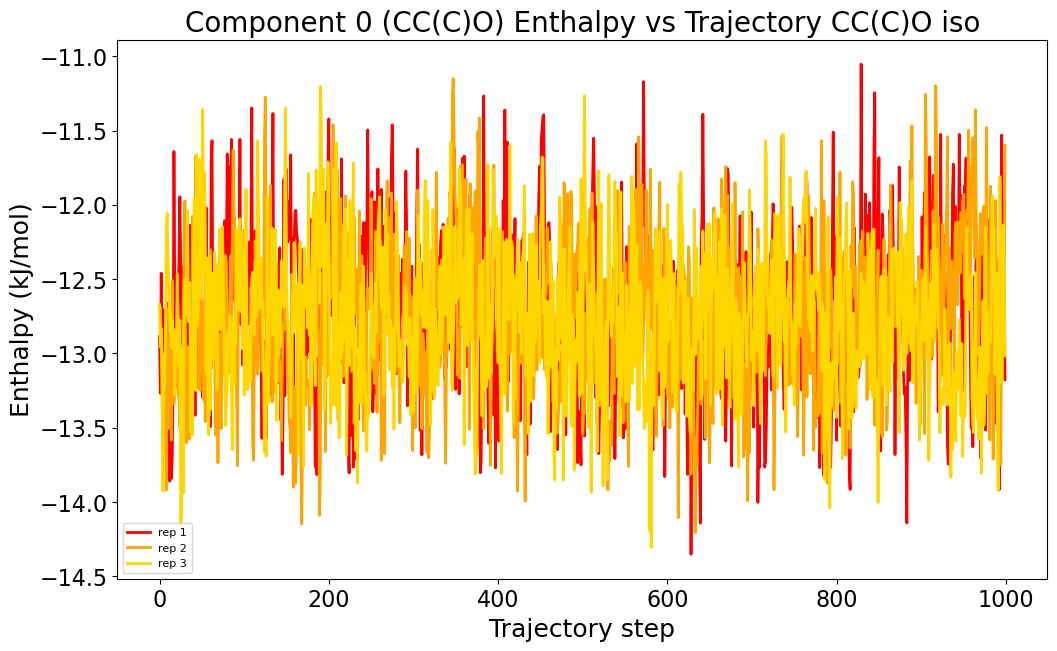

In [57]:
timeseries_overlap(c0_prod_enthalpy, 'Component 0 (CC(C)O)')

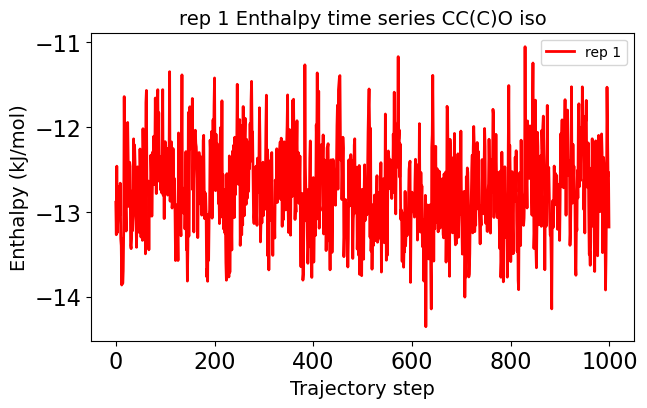

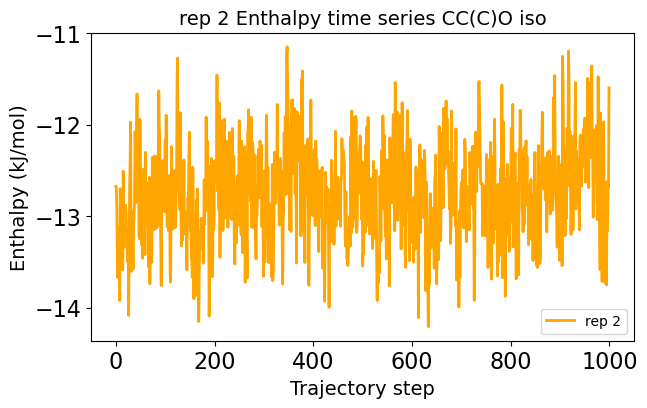

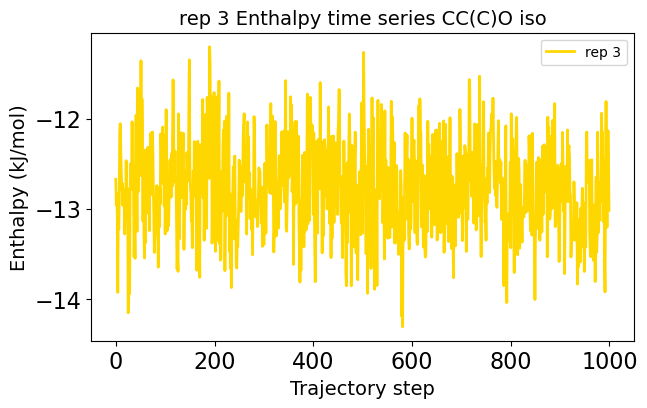

In [58]:
timeseriesplot(c0_prod_enthalpy)

mean: -12.734567369162626
stdv: 0.5307680861594481
Shapiro Statistics=0.997, p=0.034
Shapiro: Sample does not look Gaussian (reject H0)
Anderson-Darling Statistic: 0.690
Anderson-Darling: 15.000: 0.574, data does not look normal (reject H0)
Anderson-Darling: 10.000: 0.653, data does not look normal (reject H0)
Anderson-Darling: 5.000: 0.784, data looks normal (fail to reject H0)
Anderson-Darling: 2.500: 0.914, data looks normal (fail to reject H0)
Anderson-Darling: 1.000: 1.088, data looks normal (fail to reject H0)
Kolmogorov-Smirnov Statistics=0.031, p=0.281
Kolmogorov-Smirnov: Sample looks Gaussian (fail to reject H0)


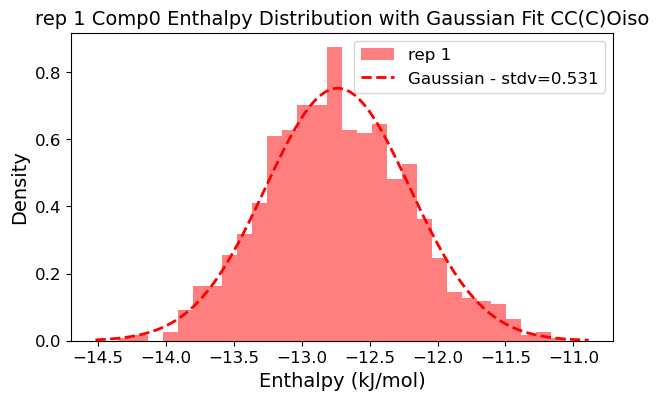

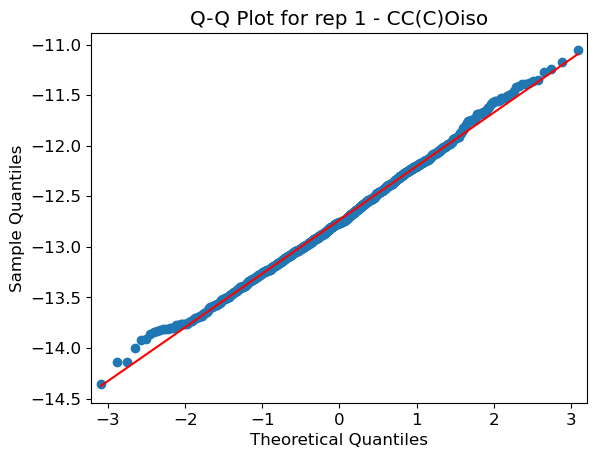

mean: -12.752172596195333
stdv: 0.524613719871375
Shapiro Statistics=0.998, p=0.224
Shapiro: Sample looks Gaussian (fail to reject H0)
Anderson-Darling Statistic: 0.318
Anderson-Darling: 15.000: 0.574, data looks normal (fail to reject H0)
Anderson-Darling: 10.000: 0.653, data looks normal (fail to reject H0)
Anderson-Darling: 5.000: 0.784, data looks normal (fail to reject H0)
Anderson-Darling: 2.500: 0.914, data looks normal (fail to reject H0)
Anderson-Darling: 1.000: 1.088, data looks normal (fail to reject H0)
Kolmogorov-Smirnov Statistics=0.020, p=0.832
Kolmogorov-Smirnov: Sample looks Gaussian (fail to reject H0)


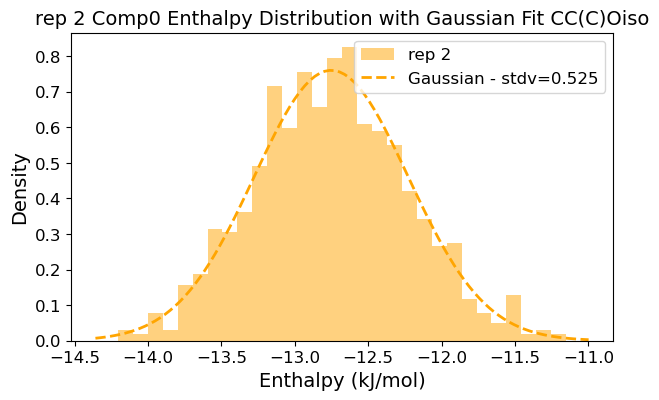

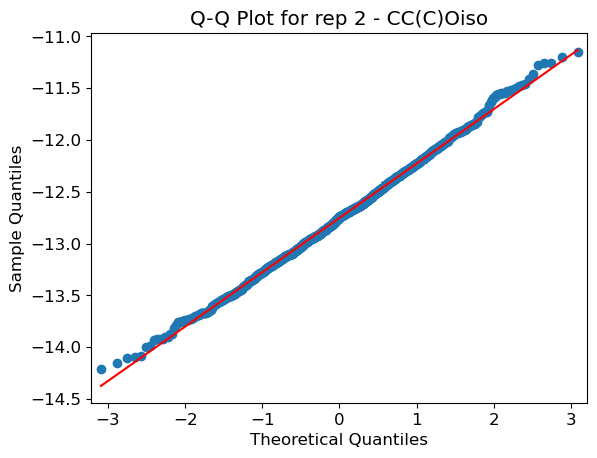

mean: -12.758108071732842
stdv: 0.49825064310095557
Shapiro Statistics=0.999, p=0.930
Shapiro: Sample looks Gaussian (fail to reject H0)
Anderson-Darling Statistic: 0.227
Anderson-Darling: 15.000: 0.574, data looks normal (fail to reject H0)
Anderson-Darling: 10.000: 0.653, data looks normal (fail to reject H0)
Anderson-Darling: 5.000: 0.784, data looks normal (fail to reject H0)
Anderson-Darling: 2.500: 0.914, data looks normal (fail to reject H0)
Anderson-Darling: 1.000: 1.088, data looks normal (fail to reject H0)
Kolmogorov-Smirnov Statistics=0.017, p=0.921
Kolmogorov-Smirnov: Sample looks Gaussian (fail to reject H0)


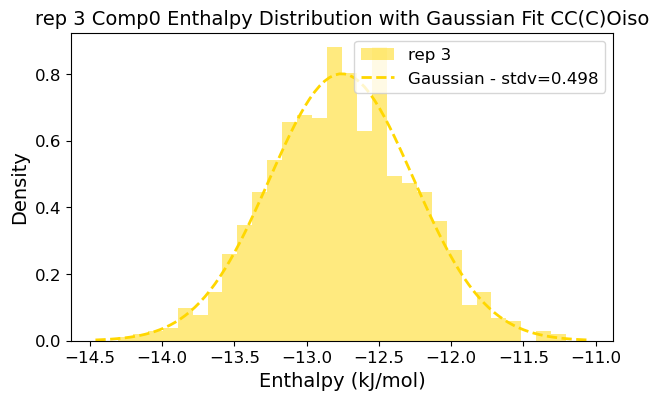

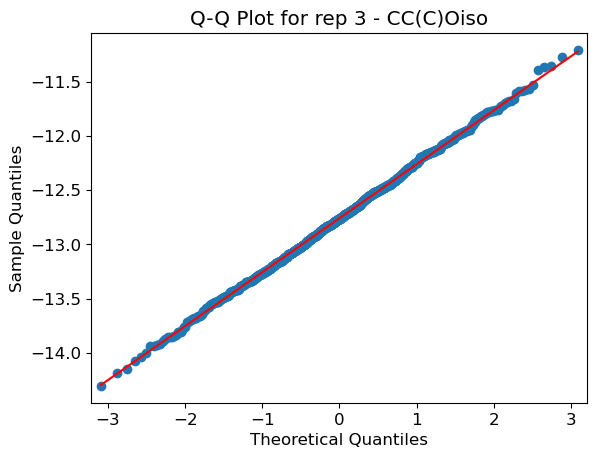

In [80]:
dists_indiv(c0_prod_enthalpy,'Comp0')

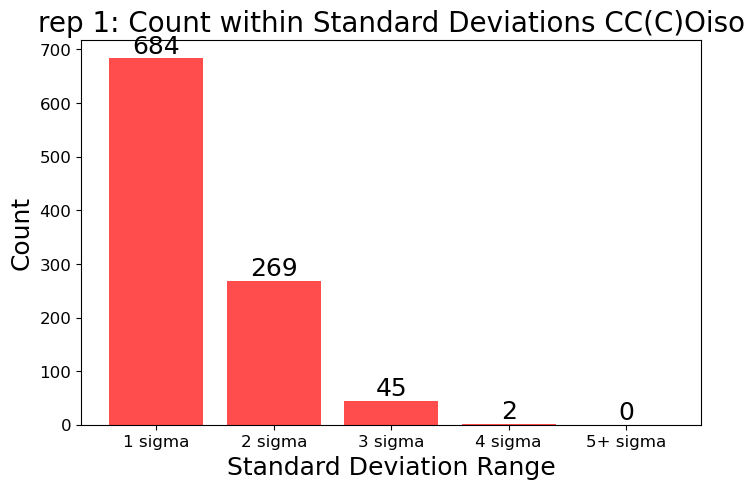

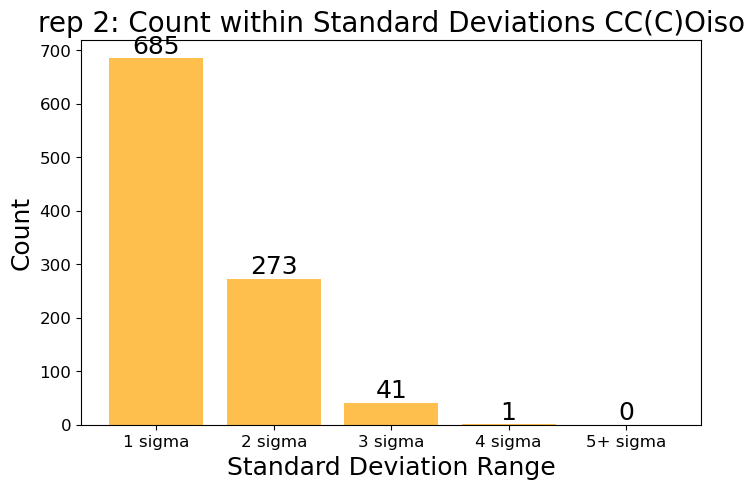

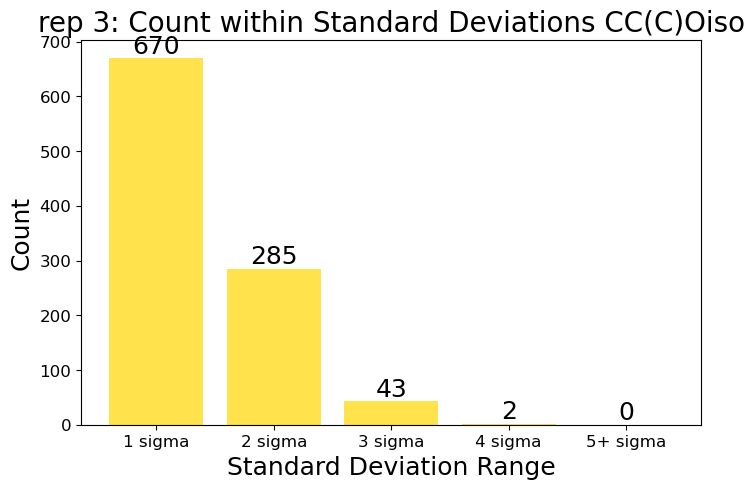

In [60]:
sigma_counts(c0_prod_enthalpy)

In [61]:
# c0_filter={}
# for i in range(6):
#     c0_filter[i] = remove_outliers(c0_prod_enthalpy[i])

# filtered_results(c0_filter)

## ANALYSIS

In [62]:
def estimated_values(mole_fraction_source):
    if mole_fraction_source == 'thermoML':
        mf_c0=thermoml_MF_c0
        mf_c1=thermoml_MF_c1
    elif mole_fraction_source == 'evaluator':
        mf_c0=evaluator_MF_c0
        mf_c1=evaluator_MF_c1

    for i in range(6):
        estimated=mixout_values[i]-(mf_c1*comp1_values[i]+mf_c0*comp0_values[i])
        est_error=np.sqrt((mf_c1*comp1_errors[i])**2 + (mf_c0*comp0_errors[i])**2 + mixout_errors[i]**2)
        print(f'rep #{i+1}: {estimated} +/- {est_error}')

In [63]:
estimated_values('thermoML')

NameError: name 'thermoml_MF_c0' is not defined

In [ ]:
estimated_values('evaluator')

rep #1: 0.6983296817504829 +/- 0.012572957824535137
rep #2: 0.7453252278187463 +/- 0.010427206870113843
rep #3: 0.7118226315102589 +/- 0.01349344216865499
rep #4: 0.7237080765208965 +/- 0.013597134227698893
rep #5: 0.70415695269471 +/- 0.015251318863286047
rep #6: 0.6872069372336505 +/- 0.011595029996755334
